<a href="https://colab.research.google.com/github/sofiabuono7/QM2/blob/main/Copy_of_Final_Version_with_order_sorted_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install seaborn
!pip install matplotlib
!pip install esda
!pip install Pillow
!pip install geopandas libpysal mgwr
# !pip install pycairo
# !pip install generativepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 15.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from statsmodels.formula.api import ols
from esda.moran import Moran
from libpysal.weights import Queen
import geopandas as gpd
import requests
import json
from prettytable import PrettyTable
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col

In [3]:
geojson_path = "/content/drive/MyDrive/Colab Notebooks/Sofi/Local_Authority_(Lower_Tier)_IMD_2019_(WGS84).geojson"

## **Cleaning and Merging the data** ##

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})

In [6]:
xls = pd.ExcelFile('/content/drive/MyDrive/Colab Notebooks/Sofi/original_datasets/imd.xlsx')
sheet_dict = {}
for sheet_name in xls.sheet_names:
    sheet_dict[sheet_name] = pd.read_excel(xls, sheet_name)
    col_count = sheet_dict[sheet_name].shape[1]
    if col_count >= 5:
        sheet_dict[sheet_name] = sheet_dict[sheet_name].iloc[:, [0, 1, 4]]
    else:
      pass

In [7]:
dfs = [sheet_dict['IMD'], sheet_dict['Income'], sheet_dict['Employment'], sheet_dict['Education'], sheet_dict['Health'], sheet_dict['Crime'], sheet_dict['Barriers'], sheet_dict['Living']]

for df in dfs:
    df.rename(columns={df.columns[0]: 'district_code'}, inplace=True)
    df.rename(columns={df.columns[1]: 'district_name'}, inplace=True)

In [8]:
from functools import reduce

deprivation_factors = reduce(lambda left, right: pd.merge(left, right, on='district_code', how='inner'), dfs)

<ipython-input-8-beb6cd4ec34a>:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'district_name_x'} in the result is deprecated and will raise a MergeError in a future version.
  deprivation_factors = reduce(lambda left, right: pd.merge(left, right, on='district_code', how='inner'), dfs)
<ipython-input-8-beb6cd4ec34a>:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'district_name_x'} in the result is deprecated and will raise a MergeError in a future version.
  deprivation_factors = reduce(lambda left, right: pd.merge(left, right, on='district_code', how='inner'), dfs)
<ipython-input-8-beb6cd4ec34a>:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'district_name_x'} in the result is deprecated and will raise a MergeError in a future version.
  deprivation_factors = reduce(lambda left, right: pd.merge(left, right, on='district_code', how='inner'), dfs)


In [9]:
duplicate_deprivation_factors = [col for col in deprivation_factors.columns if col.startswith('district_name') and col != 'district_name']

deprivation_factors.drop(columns=duplicate_deprivation_factors, inplace=True)
deprivation_factors

,district_code,IMD - Average score,Income - Average score,Employment - Average score,"Education, Skills and Training - Average score",Health Deprivation and Disability - Average score,Crime - Average score,Barriers to Housing and Services - Average score,Living Environment - Average score
0,E06000001,35.037,0.228,0.185,30.255,0.869,0.566,14.242,6.943
1,E06000002,40.460,0.251,0.191,38.850,1.194,0.701,14.183,12.929
2,E06000003,29.792,0.186,0.165,27.768,0.790,0.138,14.139,7.793
3,E06000004,25.790,0.164,0.135,24.786,0.684,-0.111,15.870,6.007
4,E06000005,25.657,0.153,0.128,27.402,0.532,0.558,11.942,8.800
...,...,...,...,...,...,...,...,...,...
312,E09000029,13.987,0.095,0.070,11.953,-0.570,-0.174,22.792,21.317
313,E09000030,27.913,0.192,0.100,16.934,0.195,0.509,30.491,33.213
314,E09000031,25.209,0.152,0.093,16.968,-0.161,0.406,36.465,34.303
315,E09000032,16.611,0.107,0.064,6.649,-0.388,0.118,26.981,32.499


In [10]:
deprivation_factors.iloc[:, 1:] = deprivation_factors.iloc[:, 1:].replace('\.', '', regex=True)
deprivation_factors.head()

,district_code,IMD - Average score,Income - Average score,Employment - Average score,"Education, Skills and Training - Average score",Health Deprivation and Disability - Average score,Crime - Average score,Barriers to Housing and Services - Average score,Living Environment - Average score
0,E06000001,35.037,0.228,0.185,30.255,0.869,0.566,14.242,6.943
1,E06000002,40.460,0.251,0.191,38.850,1.194,0.701,14.183,12.929
2,E06000003,29.792,0.186,0.165,27.768,0.790,0.138,14.139,7.793
3,E06000004,25.790,0.164,0.135,24.786,0.684,-0.111,15.870,6.007
4,E06000005,25.657,0.153,0.128,27.402,0.532,0.558,11.942,8.800


In [11]:
# Differs from original df as population density was calculated using rounded area (e.g. London as 3km rather than 2.7km etc.)
# Provides more accurate df

population = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Sofi/original_datasets/population.xls", sheet_name='MYE 5')
population = population.iloc[3:]
population.columns = population.iloc[0]
population = population.drop(population.index[0])
population = population.iloc[:, [0, 1, 4, 5]]

population.rename(columns={'Code': 'district_code'}, inplace=True)
population.rename(columns={'Estimated Population mid-2019': 'total_population'}, inplace=True)
population = population.drop(columns = 'total_population')

population.head()

3,district_code,Name,2019 people per sq. km
4,K02000001,UNITED KINGDOM,275
5,K03000001,GREAT BRITAIN,283
6,K04000001,ENGLAND AND WALES,394
7,E92000001,ENGLAND,432
8,E12000001,NORTH EAST,311


In [12]:
marriage = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Sofi/original_datasets/marriage.xlsx", sheet_name='1')
marriage = marriage.iloc[4:]
marriage.columns = marriage.iloc[0]
marriage = marriage.drop(marriage.index[0])

marriage.iloc[:, 2:] = marriage.iloc[:, 2:].replace('c', 0)
cols_to_convert = marriage.columns[3:]
marriage[cols_to_convert] = marriage[cols_to_convert].apply(pd.to_numeric, errors='coerce')
marriage['Population'] = marriage[cols_to_convert].sum(axis=1)
marriage['Proportionate Marriage Rate'] = marriage['Married or in a civil partnership (value)']/marriage['Population']

population_by_ladc = marriage.groupby('Area code').agg(Total_Population=('Population', 'sum')).reset_index()

marriage['Total_Married'] = marriage['Married or in a civil partnership (value)']
total_married_by_town = marriage.groupby('Area code').agg(Total_Married=('Total_Married', 'sum')).reset_index()
total_married_by_town['Marriage Rate'] = total_married_by_town['Total_Married'] / population_by_ladc['Total_Population']
total_married_by_town['district_code'] = total_married_by_town['Area code']
total_married_by_town = total_married_by_town.drop(columns = 'Area code')

total_married_by_town.head()

,Total_Married,Marriage Rate,district_code
0,31545,0.422544,E06000001
1,44925,0.394321,E06000002
2,49420,0.439915,E06000003
3,72000,0.455624,E06000004
4,38970,0.442464,E06000005


In [13]:
religion = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Sofi/original_datasets/religion.xlsx", sheet_name='Figure 2')
religion = religion.iloc[3:]
religion.columns = religion.iloc[0]
religion = religion.drop(religion.index[0])
religion = religion.iloc[:, :10]


religion.iloc[:, 2:] = religion.iloc[:, 2:].replace('-', 0)
convert = religion.columns[2:]
religion[convert] = religion[convert].apply(pd.to_numeric, errors='coerce')
religion['Total'] = religion[convert].sum(axis=1)
religion['Religious'] = religion.iloc[:, 3:10].sum(axis=1)
religion['religious_rate'] = religion['Religious']/religion['Total']

overall_religion = religion.iloc[:, [0, 1, 12]]
overall_religion.rename(columns={'Area code': 'district_code'}, inplace=True)

overall_religion.head()

<ipython-input-13-f8ef40ecbe24>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_religion.rename(columns={'Area code': 'district_code'}, inplace=True)


3,district_code,Area name,religious_rate
4,E06000001,Hartlepool,0.577601
5,E06000002,Middlesbrough,0.615277
6,E06000003,Redcar and Cleveland,0.575181
7,E06000004,Stockton-on-Tees,0.588367
8,E06000005,Darlington,0.582646


In [14]:
overall_dfs = [deprivation_factors, total_married_by_town, overall_religion, population]

overall_data = reduce(lambda left, right: pd.merge(left, right, on='district_code', how='inner'), overall_dfs)
cols = overall_data.columns.tolist()
overall_data = overall_data[cols]

cols = overall_data.columns.tolist()
last_col = cols.pop(-2)
cols.insert(1, last_col)
overall_data = overall_data[cols]
overall_data = overall_data.drop(columns = 'Area name')
overall_data = overall_data.drop(columns = 'Total_Married')

overall_data.head()

,district_code,Name,IMD - Average score,Income - Average score,Employment - Average score,"Education, Skills and Training - Average score",Health Deprivation and Disability - Average score,Crime - Average score,Barriers to Housing and Services - Average score,Living Environment - Average score,Marriage Rate,religious_rate,2019 people per sq. km
0,E06000001,Hartlepool,35.037,0.228,0.185,30.255,0.869,0.566,14.242,6.943,0.422544,0.577601,999
1,E06000002,Middlesbrough,40.460,0.251,0.191,38.850,1.194,0.701,14.183,12.929,0.394321,0.615277,2616
2,E06000003,Redcar and Cleveland,29.792,0.186,0.165,27.768,0.790,0.138,14.139,7.793,0.439915,0.575181,560
3,E06000004,Stockton-on-Tees,25.790,0.164,0.135,24.786,0.684,-0.111,15.870,6.007,0.455624,0.588367,963
4,E06000005,Darlington,25.657,0.153,0.128,27.402,0.532,0.558,11.942,8.800,0.442464,0.582646,541


In [15]:
overall_data.columns

Index(['district_code', 'Name', 'IMD - Average score ',
       'Income - Average score ', 'Employment - Average score ',
       'Education, Skills and Training - Average score ',
       'Health Deprivation and Disability - Average score ',
       'Crime - Average score ',
       'Barriers to Housing and Services - Average score ',
       'Living Environment - Average score ', 'Marriage Rate',
       'religious_rate', '2019 people per sq. km'],
      dtype='object')

In [16]:
new_column_names = ['district_code', 'district_name', 'imd', 'income', 'employment', 'education', 'health', 'crime', 'barriers', 'living_environment', 'marriage_rate', 'religious_rate', 'population_density']

columns_to_convert = ['marriage_rate', 'imd', 'religious_rate', 'population_density', 'income', 'employment', 'education', 'health', 'crime', 'barriers', 'living_environment']

overall_data.columns = new_column_names

for column in columns_to_convert:
    overall_data[column] = pd.to_numeric(overall_data[column], errors='coerce')

overall_data.head()

,district_code,district_name,imd,income,employment,education,health,crime,barriers,living_environment,marriage_rate,religious_rate,population_density
0,E06000001,Hartlepool,35.037,0.228,0.185,30.255,0.869,0.566,14.242,6.943,0.422544,0.577601,999
1,E06000002,Middlesbrough,40.460,0.251,0.191,38.850,1.194,0.701,14.183,12.929,0.394321,0.615277,2616
2,E06000003,Redcar and Cleveland,29.792,0.186,0.165,27.768,0.790,0.138,14.139,7.793,0.439915,0.575181,560
3,E06000004,Stockton-on-Tees,25.790,0.164,0.135,24.786,0.684,-0.111,15.870,6.007,0.455624,0.588367,963
4,E06000005,Darlington,25.657,0.153,0.128,27.402,0.532,0.558,11.942,8.800,0.442464,0.582646,541


In [17]:
overall_data.columns

Index(['district_code', 'district_name', 'imd', 'income', 'employment',
       'education', 'health', 'crime', 'barriers', 'living_environment',
       'marriage_rate', 'religious_rate', 'population_density'],
      dtype='object')

## **Variables** ##

In [18]:
x1 = overall_data[['imd']]
x2 = overall_data[['religious_rate']]
x3 = overall_data[['population_density']]
y = overall_data[['marriage_rate']]

column_names = [col for col in overall_data.columns if col not in ['marriage_rate', 'area_code', 'area_name', 'IDACI', 'IDAOPI', 'IMD']]

## **Descriptive Statistics** ##

This section presents a comprehensive analysis of our variables, including summary statistics, box plots, and histograms to understand data distribution and relationships.

### ***Summary Statistics*** ###

In [19]:
data_descriptive = overall_data.iloc[:, 2:]

# Describe data to get summary statistics
stats = data_descriptive.describe().round(3)
stats = stats.T

# Setup the PrettyTable
table = PrettyTable()
table.field_names = ["Variable", "Mean", "St. Dev.", "Min", "25%", "50%", "75%", "Max"]
table.title = "Summary Statistics"

# Add data to the table
for row in stats.iterrows():
    table.add_row([row[0], row[1]["mean"], row[1]["std"], row[1]["min"], row[1]["25%"], row[1]["50%"], row[1]["75%"], row[1]["max"]])

# Print the table
print(table)

+----------------------------------------------------------------------------------------+
|                                   Summary Statistics                                   |
+--------------------+----------+----------+--------+--------+--------+--------+---------+
|      Variable      |   Mean   | St. Dev. |  Min   |  25%   |  50%   |  75%   |   Max   |
+--------------------+----------+----------+--------+--------+--------+--------+---------+
|        imd         |  19.789  |  7.986   | 5.544  | 13.322 | 18.584 | 25.599 |  45.039 |
|       income       |  0.117   |  0.046   | 0.029  | 0.079  | 0.108  | 0.148  |  0.251  |
|     employment     |  0.093   |  0.035   | 0.019  | 0.065  | 0.089  | 0.113  |  0.209  |
|     education      |  20.792  |  8.749   | 3.534  | 13.971 | 19.08  | 27.196 |  42.053 |
|       health       |  -0.125  |  0.645   | -2.625 | -0.59  | -0.129 | 0.352  |  1.643  |
|       crime        |  -0.139  |  0.521   | -1.656 | -0.526 | -0.137 | 0.255  |  1.206  |

### ***Outliers*** ###

In [20]:
def filter_outliers(var):
    q1 = var.quantile(0.25) # calculate the first quartile
    q3 = var.quantile(0.75) # calculate the third quartile
    iqr = q3 - q1 # calculate the interquartile range
    low = q1 - 3*iqr # calculate the lower bound
    high = q3 + 3*iqr # calculate the upper bound
    filtered = overall_data[(var > low) & (var < high)] # filter  the values that are within the bounds
    dropped_observations= len(var)-len(filtered) # calculate the number of observations that were dropped

    print('Dropped {} observations'.format(dropped_observations))
    return  filtered

#Filter outliers
reg_df=filter_outliers(overall_data['imd'])
reg_df=filter_outliers(overall_data['marriage_rate'])
reg_df=filter_outliers(overall_data['religious_rate'])
reg_df=filter_outliers(overall_data['population_density'])
reg_df=filter_outliers(overall_data['income'])
reg_df=filter_outliers(overall_data['employment'])
reg_df=filter_outliers(overall_data['education'])
reg_df=filter_outliers(overall_data['health'])
reg_df=filter_outliers(overall_data['crime'])
reg_df=filter_outliers(overall_data['barriers'])
reg_df=filter_outliers(overall_data['living_environment'])

Dropped 0 observations
Dropped 0 observations
Dropped 0 observations
Dropped 12 observations
Dropped 0 observations
Dropped 0 observations
Dropped 0 observations
Dropped 0 observations
Dropped 0 observations
Dropped 1 observations
Dropped 1 observations


In [21]:
# Create an instance of PrettyTable
table = PrettyTable()

# Define the column names
table.field_names = ["Variable", "Observations Dropped"]

# Add rows to the table with the data
table.add_row(["imd", 0])
table.add_row(["marriage_rate", 0])
table.add_row(["religious_rate", 0])
table.add_row(["population_density", 12])
table.add_row(["income", 0])
table.add_row(["employment", 0])
table.add_row(["education", 0])
table.add_row(["health", 0])
table.add_row(["crime", 1])
table.add_row(["barriers", 1])
table.add_row(["living_environment", 1])

# Print the table
print(table)


+--------------------+----------------------+
|      Variable      | Observations Dropped |
+--------------------+----------------------+
|        imd         |          0           |
|   marriage_rate    |          0           |
|   religious_rate   |          0           |
| population_density |          12          |
|       income       |          0           |
|     employment     |          0           |
|     education      |          0           |
|       health       |          0           |
|       crime        |          1           |
|      barriers      |          1           |
| living_environment |          1           |
+--------------------+----------------------+


### ***Box Plots*** ###

Reference: https://plotly.com/python/box-plots/

In [22]:
# Create the Box Plot
import plotly.express as px

fig = px.box(overall_data, y='imd', title= 'Box Plot of Index of Multiple Deprivation Average Score, UK 2019')

fig.show()

In [23]:
# Create the Box Plot
fig = px.box(overall_data, y='marriage_rate', title='Box Plot of Marriage rate (%), UK 2019')

fig.update_yaxes(title_text='Marriage Rate')

fig.show()

In [24]:
# Create the Box Plot

fig = px.box(overall_data, y='population_density')

fig.update_layout(title_text=f'Box Plot of Population Density (per square km), UK 2019')

fig.update_yaxes(title_text='Population Density (per square km)')

fig.show()

In [25]:
# Create the Box Plot

fig = px.box(overall_data, y='religious_rate')

fig.update_layout(title_text=f'Box Plot of Rate of Religious Individuals (%), UK 2019')
fig.update_yaxes(title_text='Rate of Religious Individuals')

fig.show()

### ***Marriage Rate Histogram*** ###

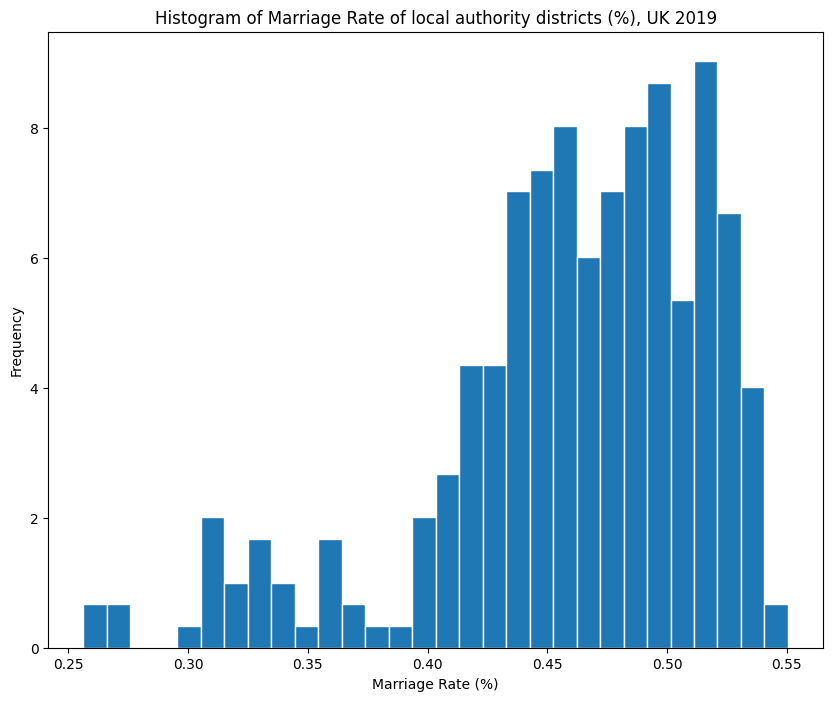

In [26]:
plt.hist(reg_df['marriage_rate'], bins=30, edgecolor='white', density=True)

plt.ylabel('Frequency')
plt.xlabel('Marriage Rate (%)') # add a label to the x axis
plt.title("Histogram of Marriage Rate of local authority districts (%), UK 2019")
plt.show()

### ***IMD Score Histogram*** ###

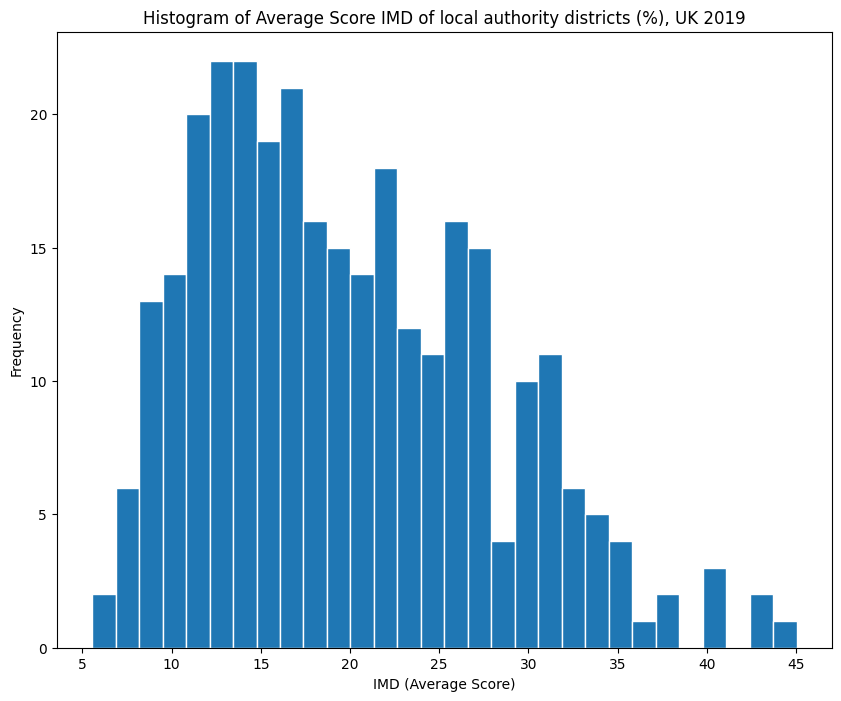

In [27]:
plt.hist(reg_df['imd'], bins=30, edgecolor='white')

plt.ylabel('Frequency')
plt.xlabel('IMD (Average Score)') # add a label to the x axis
plt.title("Histogram of Average Score IMD of local authority districts (%), UK 2019")
plt.show()

### ***Religious Rate Histogram*** ###

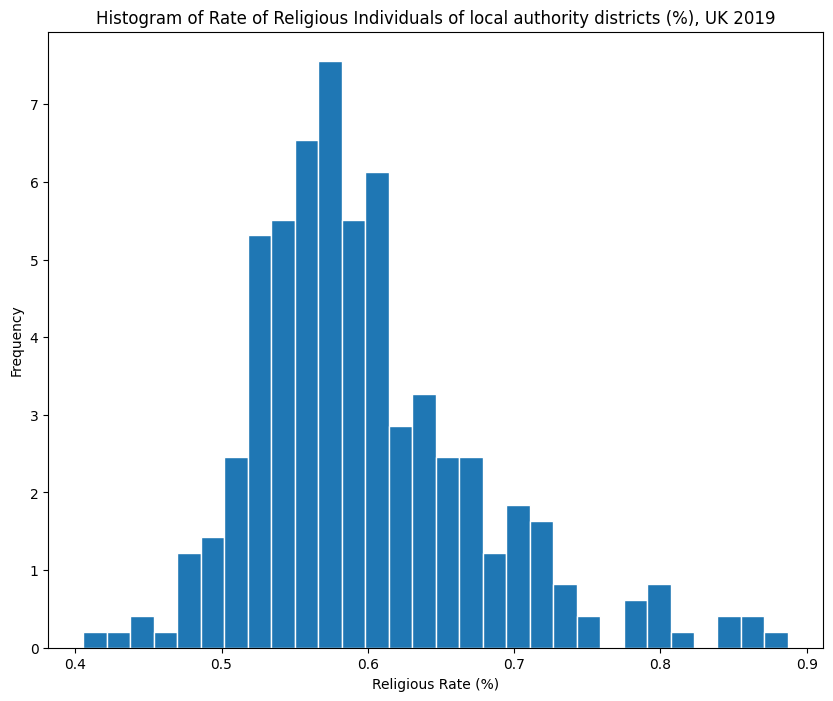

In [28]:
plt.hist(reg_df['religious_rate'], bins=30, edgecolor='white', density=True)

plt.ylabel('Frequency')
plt.xlabel('Religious Rate (%)') # add a label to the x axis
plt.title("Histogram of Rate of Religious Individuals of local authority districts (%), UK 2019")
plt.show()

### ***Population Density Histogram*** ###

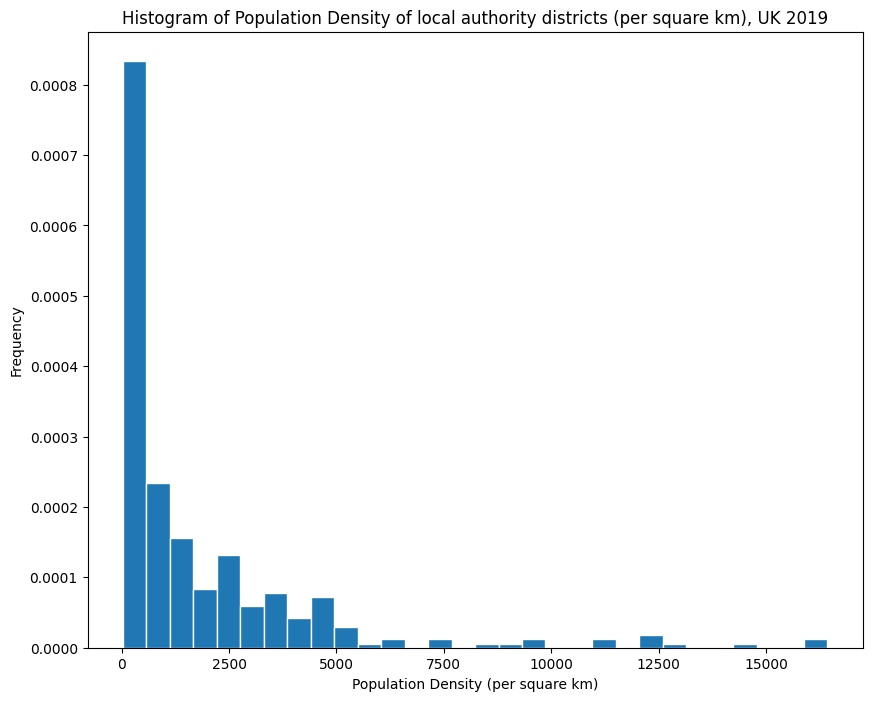

In [29]:
plt.hist(reg_df['population_density'], bins=30, edgecolor='white', density=True)

plt.ylabel('Frequency')
plt.xlabel('Population Density (per square km)') # add a label to the x axis
plt.title("Histogram of Population Density of local authority districts (per square km), UK 2019")
plt.show()

## **Preliminary Regression Analysis** ##

Introduction to Scatter Plots Prior to OLS Regression Analysis


### Scatter plot #1 ###

Reference: https://www.machinelearningplus.com/plots/python-scatter-plot/?utm_content=cmp-true

Text(0.5, 1.0, 'Scatter plot of IMD (Average Score) VS Marriage Rate (%), UK 2019')

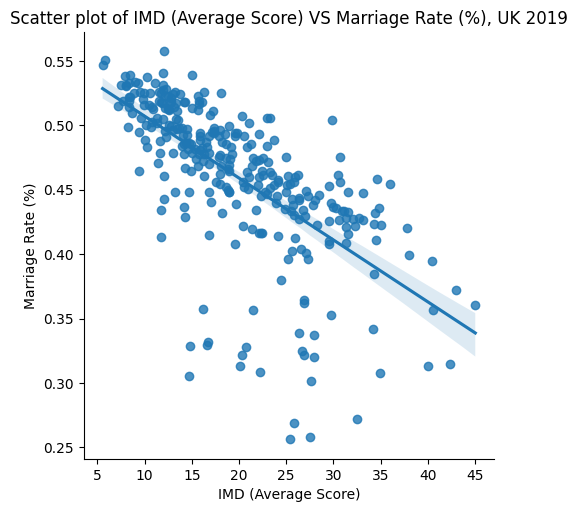

In [100]:
# Generate the scatter plot
sns.lmplot(x='imd', y='marriage_rate', data= overall_data)

plt.xlabel('IMD (Average Score)')
plt.ylabel('Marriage Rate (%)')

# Display the plot
plt.title("Scatter plot of IMD (Average Score) VS Marriage Rate (%), UK 2019")

### Scatter plot #2 ###

Text(0.5, 1.0, 'Scatter plot of Religious Rate (%) VS Marriage Rate (%), UK 2019')

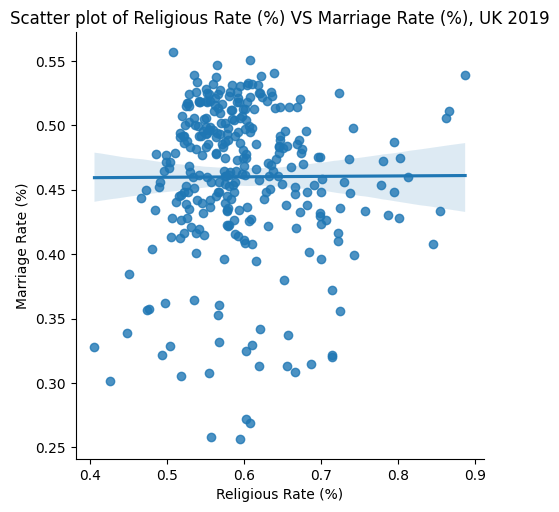

In [101]:
sns.lmplot(x='religious_rate', y='marriage_rate', data= overall_data)

plt.xlabel('Religious Rate (%)')
plt.ylabel('Marriage Rate (%)')

plt.title("Scatter plot of Religious Rate (%) VS Marriage Rate (%), UK 2019")

### Scatter plot #3 ###

Text(0.5, 1.0, 'Scatter plot of Population Density (per square km) VS Marriage Rate (%), UK 2019')

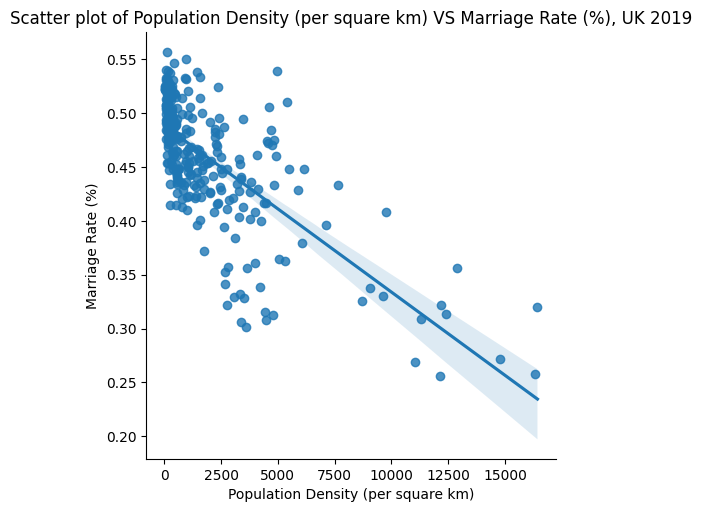

In [102]:
sns.lmplot(x='population_density', y='marriage_rate', data= overall_data)
plt.xlabel('Population Density (per square km)')
plt.ylabel('Marriage Rate (%)')
plt.title(f"Scatter plot of Population Density (per square km) VS Marriage Rate (%), UK 2019")

### Standardising the variables ###

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [35]:
overall_data

,district_code,district_name,imd,income,employment,education,health,crime,barriers,living_environment,marriage_rate,religious_rate,population_density
0,E06000001,Hartlepool,35.037,0.228,0.185,30.255,0.869,0.566,14.242,6.943,0.422544,0.577601,999
1,E06000002,Middlesbrough,40.460,0.251,0.191,38.850,1.194,0.701,14.183,12.929,0.394321,0.615277,2616
2,E06000003,Redcar and Cleveland,29.792,0.186,0.165,27.768,0.790,0.138,14.139,7.793,0.439915,0.575181,560
3,E06000004,Stockton-on-Tees,25.790,0.164,0.135,24.786,0.684,-0.111,15.870,6.007,0.455624,0.588367,963
4,E06000005,Darlington,25.657,0.153,0.128,27.402,0.532,0.558,11.942,8.800,0.442464,0.582646,541
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,E09000029,Sutton,13.987,0.095,0.070,11.953,-0.570,-0.174,22.792,21.317,0.483941,0.656084,4706
302,E09000030,Tower Hamlets,27.913,0.192,0.100,16.934,0.195,0.509,30.491,33.213,0.320131,0.714054,16427
303,E09000031,Waltham Forest,25.209,0.152,0.093,16.968,-0.161,0.406,36.465,34.303,0.395953,0.699708,7137
304,E09000032,Wandsworth,16.611,0.107,0.064,6.649,-0.388,0.118,26.981,32.499,0.329854,0.610064,9624


In [40]:
overall_data_scaled

,district_code,district_name,imd_scaled,income_scaled,employment_scaled,education_scaled,health_scaled,crime_scaled,barriers_scaled,living_environment_scaled,marriage_rate_scaled,religious_rate_scaled,population_density_scaled,cubed_marriage_rate,cubed_marriage_rate_scaled,marriage_rate,imd,religious_rate,population_density
0,E06000001,Hartlepool,1.909051,2.449123,2.666077,1.080265,1.568870,1.351263,-1.182477,-1.569034,-0.639053,-0.252146,-0.315621,0.075442,-0.798730,0.422544,35.037,0.577601,999
1,E06000002,Middlesbrough,2.589150,2.957425,2.839828,2.065280,2.086010,1.610942,-1.191831,-0.883322,-1.124628,0.230681,0.286618,0.061313,-1.230788,0.394321,40.460,0.615277,2616
2,E06000003,Redcar and Cleveland,1.251275,1.520920,2.086908,0.795247,1.443166,0.527985,-1.198808,-1.471664,-0.340185,-0.283152,-0.479123,0.085134,-0.502364,0.439915,29.792,0.575181,560
3,E06000004,Stockton-on-Tees,0.749383,1.034718,1.218154,0.453500,1.274499,0.049022,-0.924352,-1.676255,-0.069900,-0.114179,-0.329029,0.094585,-0.213397,0.455624,25.790,0.588367,963
4,E06000005,Darlington,0.732703,0.791617,1.015445,0.753302,1.032636,1.335875,-1.547149,-1.356310,-0.296325,-0.187486,-0.486199,0.086623,-0.456845,0.442464,25.657,0.582646,541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,E09000029,Sutton,-0.730833,-0.490187,-0.664146,-1.017203,-0.720865,-0.072161,0.173152,0.077546,0.417298,0.753618,1.065022,0.113338,0.360064,0.483941,13.987,0.656084,4706
301,E09000030,Tower Hamlets,1.015629,1.653520,0.204608,-0.446364,0.496402,1.241621,1.393852,1.440264,-2.401075,1.496504,5.430415,0.032808,-2.102395,0.320131,27.913,0.714054,16427
302,E09000031,Waltham Forest,0.676520,0.769517,0.001899,-0.442468,-0.070065,1.043495,2.341048,1.565126,-1.096544,1.312661,1.970429,0.062077,-1.207409,0.395953,25.209,0.699708,7137
303,E09000032,Wandsworth,-0.401757,-0.224986,-0.837896,-1.625058,-0.431267,0.489514,0.837331,1.358473,-2.233788,0.163867,2.896692,0.035889,-2.008182,0.329854,16.611,0.610064,9624


In [41]:
from sklearn.preprocessing import StandardScaler
columns_to_standardise = ['marriage_rate', 'imd', 'religious_rate', 'population_density', 'income', 'employment', 'education', 'health', 'crime', 'barriers', 'living_environment']

scaler = StandardScaler()
overall_data_scaled = reg_df.copy()
overall_data_scaled[columns_to_standardise] = scaler.fit_transform(reg_df[columns_to_standardise])
overall_data_scaled = overall_data_scaled.rename(columns = {'marriage_rate':'marriage_rate_scaled'})
overall_data_scaled = overall_data_scaled.rename(columns = {'imd':'imd_scaled'})
overall_data_scaled = overall_data_scaled.rename(columns = {'religious_rate':'religious_rate_scaled'})
overall_data_scaled = overall_data_scaled.rename(columns = {'population_density':'population_density_scaled'})
overall_data_scaled = overall_data_scaled.rename(columns = {'income':'income_scaled'})
overall_data_scaled = overall_data_scaled.rename(columns = {'employment':'employment_scaled'})
overall_data_scaled = overall_data_scaled.rename(columns = {'education':'education_scaled'})
overall_data_scaled = overall_data_scaled.rename(columns = {'health':'health_scaled'})
overall_data_scaled = overall_data_scaled.rename(columns = {'crime':'crime_scaled'})
overall_data_scaled = overall_data_scaled.rename(columns = {'barriers':'barriers_scaled'})
overall_data_scaled = overall_data_scaled.rename(columns = {'living_environment':'living_environment_scaled'})

overall_data_scaled['cubed_marriage_rate'] = overall_data['marriage_rate'] ** 3
overall_data_scaled['cubed_marriage_rate_scaled'] = scaler.fit_transform(overall_data_scaled[['cubed_marriage_rate']])

overall_data_scaled = overall_data_scaled.merge(reg_df[['district_code', 'marriage_rate', 'imd', 'religious_rate', 'population_density']], on='district_code', how='left')
overall_data_scaled

,district_code,district_name,imd_scaled,income_scaled,employment_scaled,education_scaled,health_scaled,crime_scaled,barriers_scaled,living_environment_scaled,marriage_rate_scaled,religious_rate_scaled,population_density_scaled,cubed_marriage_rate,cubed_marriage_rate_scaled,marriage_rate,imd,religious_rate,population_density
0,E06000001,Hartlepool,1.909051,2.449123,2.666077,1.080265,1.568870,1.351263,-1.182477,-1.569034,-0.639053,-0.252146,-0.315621,0.075442,-0.798730,0.422544,35.037,0.577601,999
1,E06000002,Middlesbrough,2.589150,2.957425,2.839828,2.065280,2.086010,1.610942,-1.191831,-0.883322,-1.124628,0.230681,0.286618,0.061313,-1.230788,0.394321,40.460,0.615277,2616
2,E06000003,Redcar and Cleveland,1.251275,1.520920,2.086908,0.795247,1.443166,0.527985,-1.198808,-1.471664,-0.340185,-0.283152,-0.479123,0.085134,-0.502364,0.439915,29.792,0.575181,560
3,E06000004,Stockton-on-Tees,0.749383,1.034718,1.218154,0.453500,1.274499,0.049022,-0.924352,-1.676255,-0.069900,-0.114179,-0.329029,0.094585,-0.213397,0.455624,25.790,0.588367,963
4,E06000005,Darlington,0.732703,0.791617,1.015445,0.753302,1.032636,1.335875,-1.547149,-1.356310,-0.296325,-0.187486,-0.486199,0.086623,-0.456845,0.442464,25.657,0.582646,541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,E09000029,Sutton,-0.730833,-0.490187,-0.664146,-1.017203,-0.720865,-0.072161,0.173152,0.077546,0.417298,0.753618,1.065022,0.113338,0.360064,0.483941,13.987,0.656084,4706
301,E09000030,Tower Hamlets,1.015629,1.653520,0.204608,-0.446364,0.496402,1.241621,1.393852,1.440264,-2.401075,1.496504,5.430415,0.032808,-2.102395,0.320131,27.913,0.714054,16427
302,E09000031,Waltham Forest,0.676520,0.769517,0.001899,-0.442468,-0.070065,1.043495,2.341048,1.565126,-1.096544,1.312661,1.970429,0.062077,-1.207409,0.395953,25.209,0.699708,7137
303,E09000032,Wandsworth,-0.401757,-0.224986,-0.837896,-1.625058,-0.431267,0.489514,0.837331,1.358473,-2.233788,0.163867,2.896692,0.035889,-2.008182,0.329854,16.611,0.610064,9624


## **OLS Regression** ##

### Regression Model #1 ###

In [42]:
def homoscedasticity_test(lm_results):
    print(lm_results.summary())

    # Perform the Breusch-Pagan test
    bp_test = het_breuschpagan(lm_results.resid, lm_results.model.exog)

    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print("\nBreusch-Pagan test for homoscedasticity:")
    homoscedasticity = False
    for label, value in zip(labels, bp_test):
        print(f"{label}: {value}")
        if label == "F-Test p-value":
            if value > 0.05:
                homoscedasticity = True
    if homoscedasticity:
        print("The regression convey homoscedasticity")
    else:
        print("The regression does not convey homoscedasticity")

In [43]:
import statsmodels.formula.api as smf
from scipy import stats
# Fit a linear regression model and store the results in lm_results_1
lm_results_1 = smf.ols('marriage_rate ~ imd_scaled', data=overall_data_scaled).fit()

homoscedasticity_test(lm_results_1)

                            OLS Regression Results                            
Dep. Variable:          marriage_rate   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     227.9
Date:                Thu, 28 Dec 2023   Prob (F-statistic):           8.86e-39
Time:                        20:41:28   Log-Likelihood:                 520.53
No. Observations:                 305   AIC:                            -1037.
Df Residuals:                     303   BIC:                            -1030.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4597      0.003    182.225      0.0

In [103]:
from tabulate import tabulate

# Assign the actual LM test results to variables
lm_statistic = 4.947847597611243
lm_pvalue = 0.02612317219835892

# Define the data for the table
bp_lm_test_data = [
    ["Test Statistic", lm_statistic],
    ["p-value", lm_pvalue]
]

# Create the table using tabulate
bp_lm_test_table = tabulate(bp_lm_test_data, headers=["Test", "Value"], tablefmt="pretty")

# Print the table
print("Results of the Breusch-Pagan Test Model 1")
print(bp_lm_test_table)


Results of the Breusch-Pagan Test Model 1
+----------------+---------------------+
|      Test      |        Value        |
+----------------+---------------------+
| Test Statistic |  4.947847597611243  |
|    p-value     | 0.02612317219835892 |
+----------------+---------------------+


As the p-value of Breusch-Pagan test was below 0.05, the regression model does not convey Homoscedasticity.

Hence, we will try transforming marriage_rate.



In [45]:
# As marriage rate is right skewed, we will use sqrt transformation to normalise the data
overall_data_scaled['cubed_marriage_rate'] = overall_data_scaled['marriage_rate'] ** 3

lm_results_1 = smf.ols('cubed_marriage_rate ~ imd_scaled', data=overall_data_scaled).fit()

homoscedasticity_test(lm_results_1)

                             OLS Regression Results                            
Dep. Variable:     cubed_marriage_rate   R-squared:                       0.500
Model:                             OLS   Adj. R-squared:                  0.499
Method:                  Least Squares   F-statistic:                     303.4
Date:                 Thu, 28 Dec 2023   Prob (F-statistic):           1.44e-47
Time:                         20:41:28   Log-Likelihood:                 716.22
No. Observations:                  305   AIC:                            -1428.
Df Residuals:                      303   BIC:                            -1421.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1016      0.001     76.47

In [104]:
from tabulate import tabulate

# Assign the actual LM test results to variables
lm_statistic = 0.6405040441249954
lm_pvalue = 0.4235283344249836

# Define the data for the table
bp_lm_test_data = [
    ["Test Statistic", lm_statistic],
    ["p-value", lm_pvalue]
]

# Create the table using tabulate
bp_lm_test_table = tabulate(bp_lm_test_data, headers=["Test", "Value"], tablefmt="pretty")

# Print the table
print("Results of the Breusch-Pagan Test Model 1 Transformed")
print(bp_lm_test_table)


Results of the Breusch-Pagan Test Model 1 Transformed
+----------------+--------------------+
|      Test      |       Value        |
+----------------+--------------------+
| Test Statistic | 0.6405040441249954 |
|    p-value     | 0.4235283344249836 |
+----------------+--------------------+


### Regression Model #2 ###

OLS Regression Analysis: Marriage Rate, IMD Rank, Religious Rate



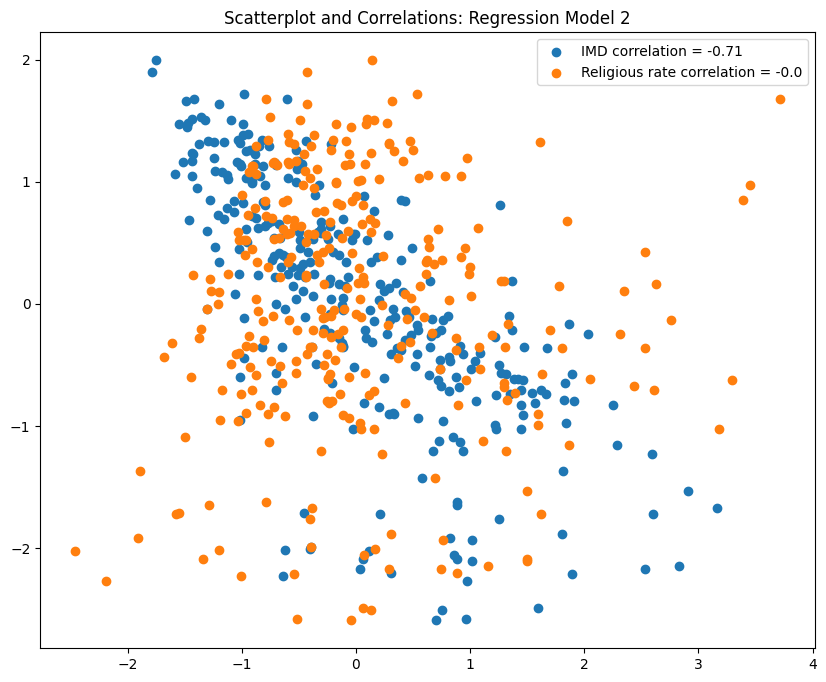

In [47]:
imd_corr = np.round(np.corrcoef(overall_data_scaled['cubed_marriage_rate_scaled'], overall_data_scaled['imd_scaled'])[0, 1], 2)
rel_rate_corr = np.round(np.corrcoef(overall_data_scaled['cubed_marriage_rate_scaled'], overall_data_scaled['religious_rate_scaled'])[0, 1], 2)

plt.scatter(overall_data_scaled['imd_scaled'], overall_data_scaled['cubed_marriage_rate_scaled'], label=f'IMD correlation = {imd_corr}')
plt.scatter(overall_data_scaled['religious_rate_scaled'], overall_data_scaled['cubed_marriage_rate_scaled'], label=f'Religious rate correlation = {rel_rate_corr}')

plt.title('Scatterplot and Correlations: Regression Model 2')
plt.legend()

plt.show()

In [48]:
import statsmodels.formula.api as smf  # Import the statsmodels library with the alias 'smf'

regression_2 = overall_data_scaled[['district_code', 'district_name', 'imd_scaled', 'religious_rate_scaled', 'cubed_marriage_rate']]

# Fit a linear regression model and store the results in lm_results_2
lm_2_results = smf.ols('cubed_marriage_rate ~ imd_scaled + religious_rate_scaled', data=regression_2).fit()

homoscedasticity_test(lm_2_results)

                             OLS Regression Results                            
Dep. Variable:     cubed_marriage_rate   R-squared:                       0.518
Model:                             OLS   Adj. R-squared:                  0.515
Method:                  Least Squares   F-statistic:                     162.5
Date:                 Thu, 28 Dec 2023   Prob (F-statistic):           1.24e-48
Time:                         20:41:29   Log-Likelihood:                 721.81
No. Observations:                  305   AIC:                            -1438.
Df Residuals:                      302   BIC:                            -1426.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

In [49]:
from tabulate import tabulate

# Assign the actual LM test results to variables
lm_statistic = 1.5215602866175089
lm_pvalue = 0.46730172245555446

# Define the data for the table
bp_lm_test_data = [
    ["Test Statistic", lm_statistic],
    ["p-value", lm_pvalue]
]

# Create the table using tabulate
bp_lm_test_table = tabulate(bp_lm_test_data, headers=["Test", "Value"], tablefmt="pretty")

# Print the table
print("Results of the Breusch-Pagan LM Test")
print(bp_lm_test_table)

Results of the Breusch-Pagan LM Test
+----------------+---------------------+
|      Test      |        Value        |
+----------------+---------------------+
| Test Statistic | 1.5215602866175089  |
|    p-value     | 0.46730172245555446 |
+----------------+---------------------+


### Regression Model #3 ###

OLS Regression Analysis: Marriage Rate, IMD Rank, Religious Rate, Population Density

In [50]:
regression_3 = overall_data_scaled[['district_code', 'district_name', 'imd_scaled', 'cubed_marriage_rate', 'religious_rate_scaled', 'population_density_scaled', 'population_density', 'cubed_marriage_rate_scaled']]
regression_3.head()

,district_code,district_name,imd_scaled,cubed_marriage_rate,religious_rate_scaled,population_density_scaled,population_density,cubed_marriage_rate_scaled
0,E06000001,Hartlepool,1.909051,0.075442,-0.252146,-0.315621,999,-0.798730
1,E06000002,Middlesbrough,2.589150,0.061313,0.230681,0.286618,2616,-1.230788
2,E06000003,Redcar and Cleveland,1.251275,0.085134,-0.283152,-0.479123,560,-0.502364
3,E06000004,Stockton-on-Tees,0.749383,0.094585,-0.114179,-0.329029,963,-0.213397
4,E06000005,Darlington,0.732703,0.086623,-0.187486,-0.486199,541,-0.456845


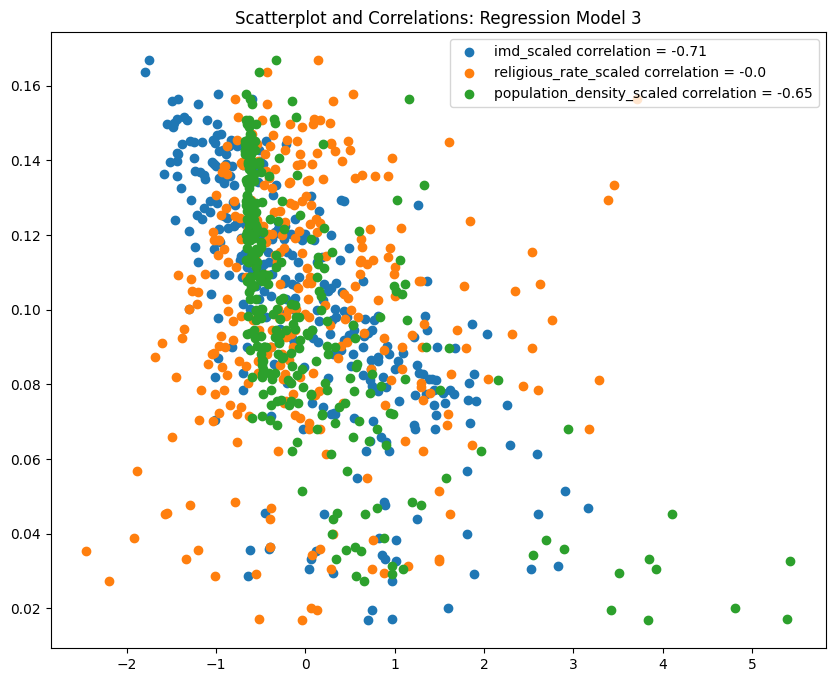

In [51]:
x1 = 'imd_scaled'
x2 = 'religious_rate_scaled'
x3 = 'population_density_scaled'

plt.scatter(regression_3['imd_scaled'], regression_3['cubed_marriage_rate'], label=f'{x1} correlation = {np.round(np.corrcoef(regression_3["cubed_marriage_rate_scaled"], regression_3["imd_scaled"])[0, 1], 2)}')
plt.scatter(regression_3['religious_rate_scaled'], regression_3['cubed_marriage_rate'], label=f'{x2} correlation = {np.round(np.corrcoef(regression_3["cubed_marriage_rate_scaled"], regression_3["religious_rate_scaled"])[0, 1], 2)}')
plt.scatter(regression_3['population_density_scaled'], regression_3['cubed_marriage_rate'], label=f'{x3} correlation = {np.round(np.corrcoef(regression_3["cubed_marriage_rate_scaled"], regression_3["population_density_scaled"])[0, 1], 2)}')

plt.title('Scatterplot and Correlations: Regression Model 3')
plt.legend()
plt.show()

In [52]:
correlation = np.round(np.corrcoef(regression_3['cubed_marriage_rate_scaled'], regression_3['imd_scaled']), 2)
correlation

array([[ 1.  , -0.71],
       [-0.71,  1.  ]])

In [53]:
overall_data_scaled

,district_code,district_name,imd_scaled,income_scaled,employment_scaled,education_scaled,health_scaled,crime_scaled,barriers_scaled,living_environment_scaled,marriage_rate_scaled,religious_rate_scaled,population_density_scaled,cubed_marriage_rate,cubed_marriage_rate_scaled,marriage_rate,imd,religious_rate,population_density
0,E06000001,Hartlepool,1.909051,2.449123,2.666077,1.080265,1.568870,1.351263,-1.182477,-1.569034,-0.639053,-0.252146,-0.315621,0.075442,-0.798730,0.422544,35.037,0.577601,999
1,E06000002,Middlesbrough,2.589150,2.957425,2.839828,2.065280,2.086010,1.610942,-1.191831,-0.883322,-1.124628,0.230681,0.286618,0.061313,-1.230788,0.394321,40.460,0.615277,2616
2,E06000003,Redcar and Cleveland,1.251275,1.520920,2.086908,0.795247,1.443166,0.527985,-1.198808,-1.471664,-0.340185,-0.283152,-0.479123,0.085134,-0.502364,0.439915,29.792,0.575181,560
3,E06000004,Stockton-on-Tees,0.749383,1.034718,1.218154,0.453500,1.274499,0.049022,-0.924352,-1.676255,-0.069900,-0.114179,-0.329029,0.094585,-0.213397,0.455624,25.790,0.588367,963
4,E06000005,Darlington,0.732703,0.791617,1.015445,0.753302,1.032636,1.335875,-1.547149,-1.356310,-0.296325,-0.187486,-0.486199,0.086623,-0.456845,0.442464,25.657,0.582646,541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,E09000029,Sutton,-0.730833,-0.490187,-0.664146,-1.017203,-0.720865,-0.072161,0.173152,0.077546,0.417298,0.753618,1.065022,0.113338,0.360064,0.483941,13.987,0.656084,4706
301,E09000030,Tower Hamlets,1.015629,1.653520,0.204608,-0.446364,0.496402,1.241621,1.393852,1.440264,-2.401075,1.496504,5.430415,0.032808,-2.102395,0.320131,27.913,0.714054,16427
302,E09000031,Waltham Forest,0.676520,0.769517,0.001899,-0.442468,-0.070065,1.043495,2.341048,1.565126,-1.096544,1.312661,1.970429,0.062077,-1.207409,0.395953,25.209,0.699708,7137
303,E09000032,Wandsworth,-0.401757,-0.224986,-0.837896,-1.625058,-0.431267,0.489514,0.837331,1.358473,-2.233788,0.163867,2.896692,0.035889,-2.008182,0.329854,16.611,0.610064,9624


In [54]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan

lm_3_results = smf.ols('cubed_marriage_rate ~ imd_scaled + religious_rate_scaled + population_density_scaled', data=overall_data_scaled).fit()

homoscedasticity_test(lm_3_results)

                             OLS Regression Results                            
Dep. Variable:     cubed_marriage_rate   R-squared:                       0.769
Model:                             OLS   Adj. R-squared:                  0.767
Method:                  Least Squares   F-statistic:                     333.9
Date:                 Thu, 28 Dec 2023   Prob (F-statistic):           2.13e-95
Time:                         20:41:30   Log-Likelihood:                 833.83
No. Observations:                  305   AIC:                            -1660.
Df Residuals:                      301   BIC:                            -1645.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept   

In [105]:
from tabulate import tabulate

# Assign the actual LM test results to variables
lm_statistic = 16.45715212039182
lm_pvalue = 0.0009137192879482212

# Define the data for the table
bp_lm_test_data = [
    ["Test Statistic", lm_statistic],
    ["p-value", lm_pvalue]
]

# Create the table using tabulate
bp_lm_test_table = tabulate(bp_lm_test_data, headers=["Test", "Value"], tablefmt="pretty")

# Print the table
print("Results of the Breusch-Pagan Test Model 3")
print(bp_lm_test_table)

Results of the Breusch-Pagan Test Model 3
+----------------+-----------------------+
|      Test      |         Value         |
+----------------+-----------------------+
| Test Statistic |   16.45715212039182   |
|    p-value     | 0.0009137192879482212 |
+----------------+-----------------------+


As the p-value of Breusch-Pagan test was below 0.05, the regression model does not convey Homoscedasticity.

Hence, we will try transforming population_density, which is newly added to Regression Model 3.

In [56]:
# As population density has extreme outlier (London), we will use inverse transformation to normalise the data
# Take cubic root of population density
overall_data_scaled['inverse_population_density'] = 1 / overall_data_scaled['population_density']
scaler = StandardScaler()
overall_data_scaled['inverse_population_density_scaled'] = scaler.fit_transform(overall_data_scaled[['inverse_population_density']])

lm_3_results = smf.ols('cubed_marriage_rate ~ imd_scaled + religious_rate_scaled + inverse_population_density_scaled', data=overall_data_scaled).fit()

homoscedasticity_test(lm_3_results)

                             OLS Regression Results                            
Dep. Variable:     cubed_marriage_rate   R-squared:                       0.623
Model:                             OLS   Adj. R-squared:                  0.619
Method:                  Least Squares   F-statistic:                     165.8
Date:                 Thu, 28 Dec 2023   Prob (F-statistic):           1.92e-63
Time:                         20:41:30   Log-Likelihood:                 759.17
No. Observations:                  305   AIC:                            -1510.
Df Residuals:                      301   BIC:                            -1495.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [106]:
from tabulate import tabulate

# Assign the actual LM test results to variables
lm_statistic = 0.8119958828201379
lm_pvalue = 0.8465956773249083

# Define the data for the table
bp_lm_test_data = [
    ["Test Statistic", lm_statistic],
    ["p-value", lm_pvalue]
]

# Create the table using tabulate
bp_lm_test_table = tabulate(bp_lm_test_data, headers=["Test", "Value"], tablefmt="pretty")

# Print the table
print("Results of the Breusch-Pagan Test Model 3 Transformed")
print(bp_lm_test_table)

Results of the Breusch-Pagan Test Model 3 Transformed
+----------------+--------------------+
|      Test      |       Value        |
+----------------+--------------------+
| Test Statistic | 0.8119958828201379 |
|    p-value     | 0.8465956773249083 |
+----------------+--------------------+


# Regression Diagnostics on Model #3


### ***Outliers*** ###


Reference: https://songhuiming.github.io/pages/2016/12/31/linear-regression-in-python-chapter-2/

Leverage v.s. Studentized Residuals


,district_code,district_name,imd_scaled,cubed_marriage_rate,religious_rate_scaled,population_density_scaled,population_density,cubed_marriage_rate_scaled,cooks,dffits,leverage,resid_student
0,E06000001,Hartlepool,1.909051,0.075442,-0.252146,-0.315621,999,-0.798730,0.004441,0.133291,0.016504,1.028931
1,E06000002,Middlesbrough,2.589150,0.061313,0.230681,0.286618,2616,-1.230788,0.006541,0.161758,0.025506,0.999857
2,E06000003,Redcar and Cleveland,1.251275,0.085134,-0.283152,-0.479123,560,-0.502364,0.001251,0.070674,0.009330,0.728249
3,E06000004,Stockton-on-Tees,0.749383,0.094585,-0.114179,-0.329029,963,-0.213397,0.000728,0.053911,0.005604,0.718154
4,E06000005,Darlington,0.732703,0.086623,-0.187486,-0.486199,541,-0.456845,0.000070,0.016716,0.005435,0.226116


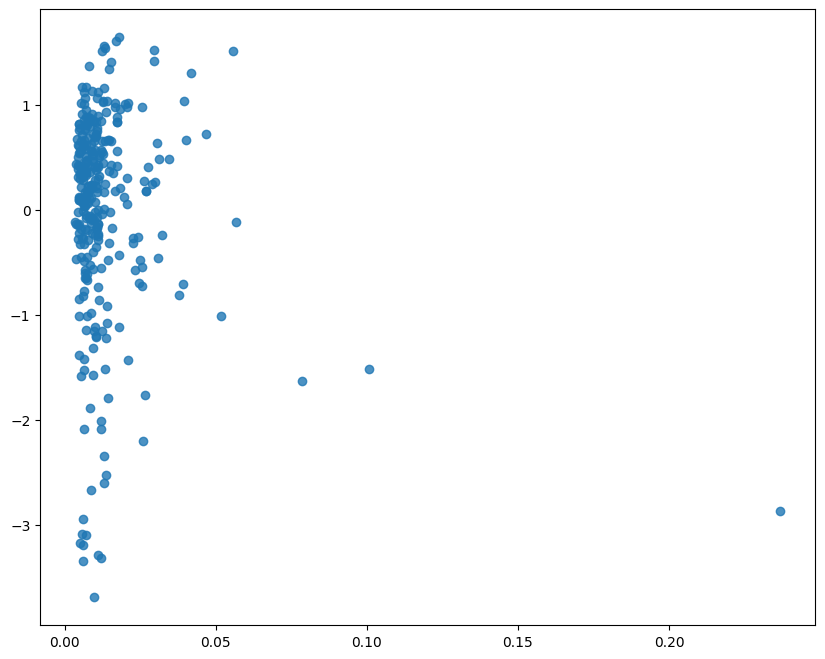

In [58]:
influence_3 = lm_3_results.get_influence()
resid_student_3 = influence_3.resid_studentized_external
(cooks_3, p) = influence_3.cooks_distance
(dffits_3, p) = influence_3.dffits
leverage_3 = influence_3.hat_matrix_diag

print('Leverage v.s. Studentized Residuals')
sns.regplot(x=leverage_3, y=lm_3_results.resid_pearson,  fit_reg=False)

regressiondiagnostics_3 = pd.concat([pd.Series(cooks_3, name = "cooks"), pd.Series(dffits_3, name = "dffits"), pd.Series(leverage_3, name = "leverage"), pd.Series(resid_student_3, name = "resid_student")], axis = 1)
regressiondiagnostics_3 = pd.concat([regression_3, regressiondiagnostics_3], axis = 1)
regressiondiagnostics_3.head()

In [59]:
r = regressiondiagnostics_3.resid_student

table = PrettyTable()
table.field_names = ['district_code', 'district_name']

for index, row in regression_3[['district_code', 'district_name']][abs(r) > 2].iterrows():
    table.add_row([row['district_code'], row['district_name']])

table.title = "Observations with studentised residuals greater than 2"

print(table)

+--------------------------------------------------------+
| Observations with studentised residuals greater than 2 |
+--------------------+-----------------------------------+
|   district_code    |           district_name           |
+--------------------+-----------------------------------+
|     E06000014      |                York               |
|     E06000043      |         Brighton and Hove         |
|     E07000008      |             Cambridge             |
|     E07000030      |                Eden               |
|     E07000041      |               Exeter              |
|     E07000178      |               Oxford              |
|     E09000001      |           City of London          |
|     E09000007      |               Camden              |
|     E09000012      |              Hackney              |
|     E09000013      |       Hammersmith and Fulham      |
|     E09000019      |             Islington             |
|     E09000020      |       Kensington and Chelsea     

In [60]:
# A point with leverage greater than (2k+2)/n should be  examined, where k is the number of predictors and n is the number of observations.
# In our example this works out to (2*4+2)/306 = 0.03267974

table = PrettyTable()
table.field_names = ['district_code', 'district_name']

#adding rows to the table
for index, row in regression_3[['district_code', 'district_name']][abs(leverage_3) > 0.03267974].iterrows():
    table.add_row([row['district_code'], row['district_name']])

#add a title
table.title = "Observations with a leverage greater than 0.026144"

#print the table
print(table)

+----------------------------------------------------+
| Observations with a leverage greater than 0.026144 |
+-----------------+----------------------------------+
|  district_code  |          district_name           |
+-----------------+----------------------------------+
|    E06000009    |            Blackpool             |
|    E06000010    |   Kingston upon Hull, City of    |
|    E06000039    |              Slough              |
|    E07000030    |               Eden               |
|    E07000047    |            West Devon            |
|    E07000163    |              Craven              |
|    E07000166    |          Richmondshire           |
|    E07000167    |             Ryedale              |
|    E08000011    |             Knowsley             |
|    E09000005    |              Brent               |
|    E09000015    |              Harrow              |
|    E09000025    |              Newham              |
|    E09000026    |            Redbridge             |
+---------

In [61]:
#Points with cooks greater than 1 are issues

table = PrettyTable()
table.field_names = ['district_code', 'district_name']

for index, row in regression_3[['district_code', 'district_name']][abs(cooks_3) > 1].iterrows():
    table.add_row([row['district_code'], row['district_name']])

table.title = "Observations with a Cook's Distance greater than 1"
print(table)

+----------------------------------------------------+
| Observations with a Cook's Distance greater than 1 |
+-------------------------+--------------------------+
|      district_code      |      district_name       |
+-------------------------+--------------------------+
+-------------------------+--------------------------+


### ***Multi Collinearity*** ###


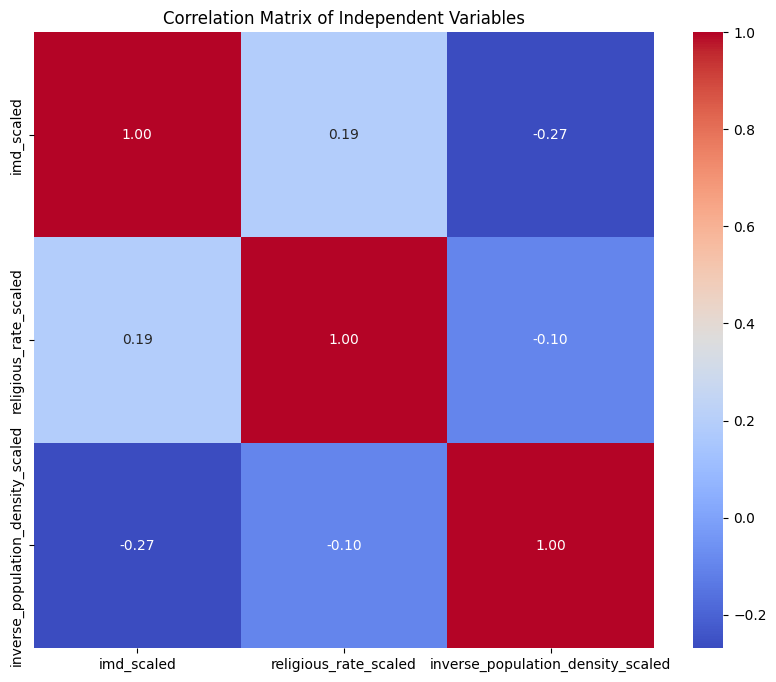

In [62]:
# Select the independent variables used in the regression model
independent_vars = overall_data_scaled[['imd_scaled', 'religious_rate_scaled', 'inverse_population_density_scaled']]

# Calculate the correlation matrix
correlation_matrix = independent_vars.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Size of the figure
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Independent Variables')
plt.show()


Vif Collinearity Analysis

Reference: https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python/51329496#51329496

In [63]:
# Define a function to calculate VIF for each independent variable and drop those with high VIF
def drop_column_using_vif(data, thresh=5.0):
    max_vif_value = 0  # Variable to store the maximum VIF value
    while True:
        # The independent variables are scaled, so we need to add a constant for VIF calculation
        data_with_const = add_constant(data)

        # Calculate VIFs
        vif_df = pd.DataFrame({
            'VIF': [variance_inflation_factor(data_with_const.values, i) for i in range(data_with_const.shape[1])],
            'variable': data_with_const.columns
        })

        # Drop the entry for the constant
        vif_df = vif_df[vif_df['variable'] != 'const']

        # Find the maximum VIF value among the variables
        max_vif = vif_df['VIF'].max()
        max_vif_value = max(max_vif, max_vif_value)  # Update the maximum VIF value if the current one is higher

        if max_vif > thresh:
            # If the maximum VIF value is above the threshold, drop that variable
            variable_to_drop = vif_df[vif_df['VIF'] == max_vif]['variable'].values[0]
            print(f"Dropping '{variable_to_drop}' with VIF {max_vif}")
            data = data.drop(columns=variable_to_drop)
        else:
            break

    return data, max_vif_value  # Return the dataframe and the maximum VIF value

# Apply the function to the selected independent variables
reduced_vars, max_vif = drop_column_using_vif(independent_vars)

# Print the remaining variables and the maximum VIF value
print("The columns remaining after VIF selection are:", reduced_vars.columns)
print("The maximum VIF value was:", max_vif)

The columns remaining after VIF selection are: Index(['imd_scaled', 'religious_rate_scaled',
       'inverse_population_density_scaled'],
      dtype='object')
The maximum VIF value was: 1.1096729016259226


In [107]:
# Create an instance of PrettyTable
table = PrettyTable()

# Define the column names
table.field_names = ["VIF analysis Model 3 Transformed", "Outcome"]

# Add rows to the table with the data
table.add_row(["Remaining columns after VIF selection", "imd_scaled, religious_rate_scaled, inverse_population_density_scaled"])
table.add_row(["Maximum VIF value", "1.1096729016259226"])

# Print the table
print(table)


+---------------------------------------+----------------------------------------------------------------------+
|    VIF analysis Model 3 Transformed   |                               Outcome                                |
+---------------------------------------+----------------------------------------------------------------------+
| Remaining columns after VIF selection | imd_scaled, religious_rate_scaled, inverse_population_density_scaled |
|           Maximum VIF value           |                          1.1096729016259226                          |
+---------------------------------------+----------------------------------------------------------------------+


### ***Normality*** ###

Reference: https://stackoverflow.com/questions/75152187/how-to-draw-histogram-qq-plots-together-for-each-column

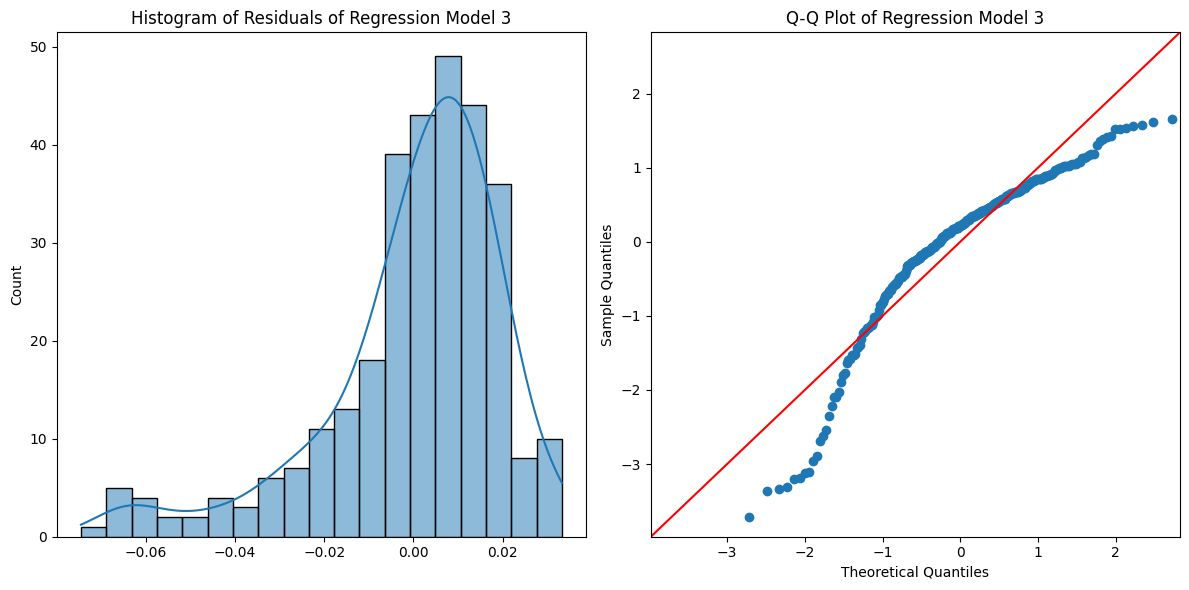

In [65]:
# Extract residuals from the regression model lm_3_results
residuals = lm_3_results.resid

# Setup the subplot framework
f, axes = plt.subplots(1, 2, figsize=(12, 6))  # Added figsize for better control over plot sizes

# Plot the histogram of the residuals
sns.histplot(residuals, kde=True, ax=axes[0])
axes[0].set_title('Histogram of Residuals of Regression Model 3')

# Generate a Q-Q plot of the residuals
sm.qqplot(residuals, line='45', fit=True, ax=axes[1])
axes[1].set_title('Q-Q Plot of Regression Model 3')

# Display the plots
plt.tight_layout()  # To ensure there's no overlap of subplots
plt.show()


### ***Homoscedasticity*** ###

Reference: https://www.kaggle.com/code/shrutimechlearn/step-by-step-assumptions-linear-regression

Breusch-Pagan test statistic: 0.8119958828201379
Breusch-Pagan test p-value: 0.8465956773249083


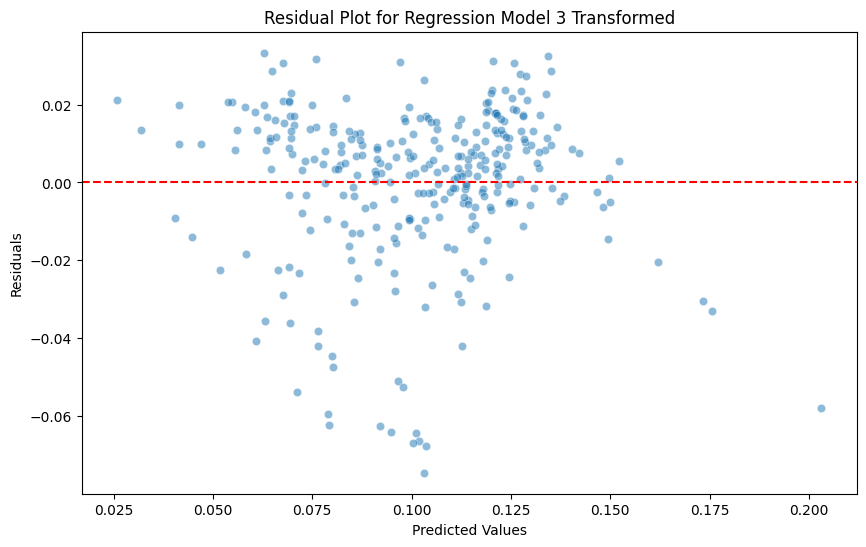

In [108]:
# Check now for homoscedasticity using the Breusch-Pagan Test

# Run the regression model
model = smf.ols('cubed_marriage_rate ~ imd_scaled + religious_rate_scaled + inverse_population_density_scaled', data=overall_data_scaled).fit()

# Take the residuals
residuals = model.resid

fitted_vals = model.predict()

# Breusch-Pagan test
bp_test = het_breuschpagan(residuals, model.model.exog)

# Output the results of the test
print('Breusch-Pagan test statistic:', bp_test[0])
print('Breusch-Pagan test p-value:', bp_test[1])

# Plot the model
fitted_vals = model.predict()
residuals = model.resid

plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.5)

plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Regression Model 3 Transformed')

plt.show()

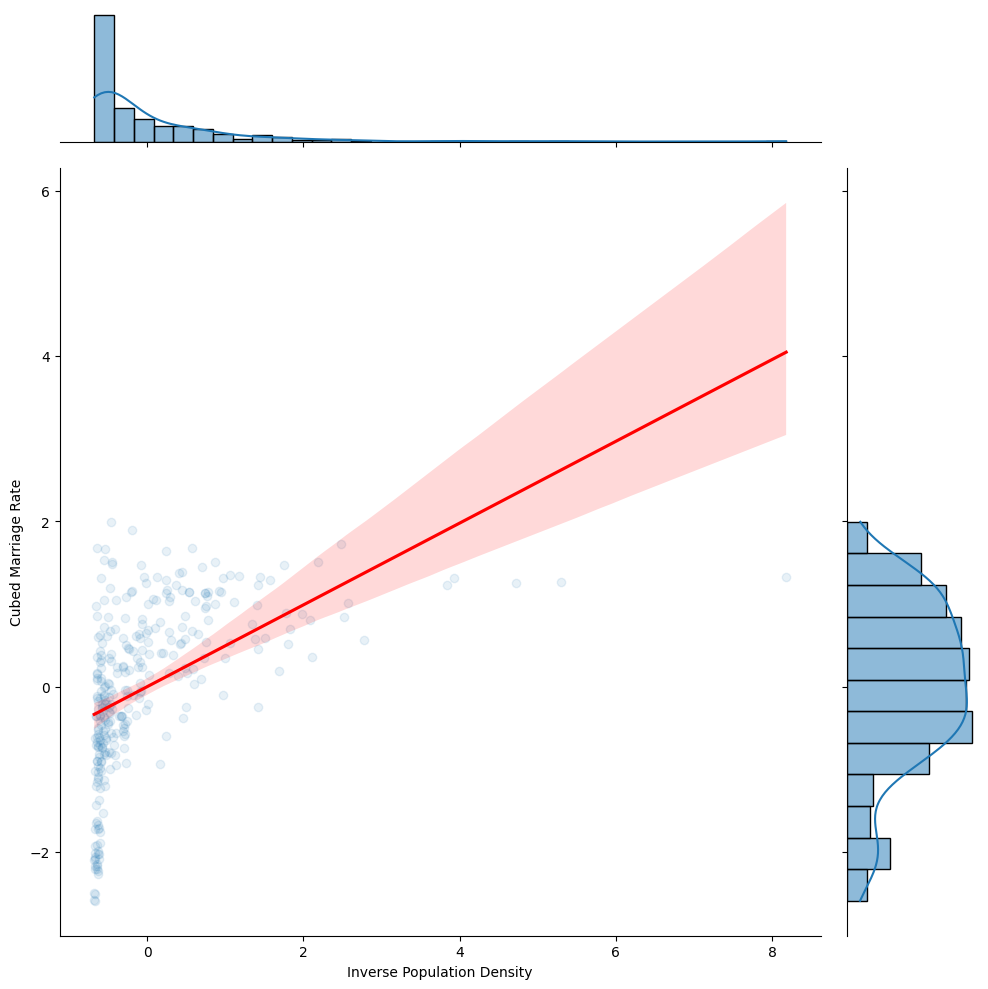

In [67]:
g = sns.jointplot(data=overall_data_scaled,
                  x='inverse_population_density_scaled',
                  y='cubed_marriage_rate_scaled',
                  kind="reg",
                  scatter_kws=dict(alpha=0.1),
                  line_kws=dict(color='red'),
                  height=10)

# Set axis labels
g.set_axis_labels('Inverse Population Density', 'Cubed Marriage Rate')

plt.show()


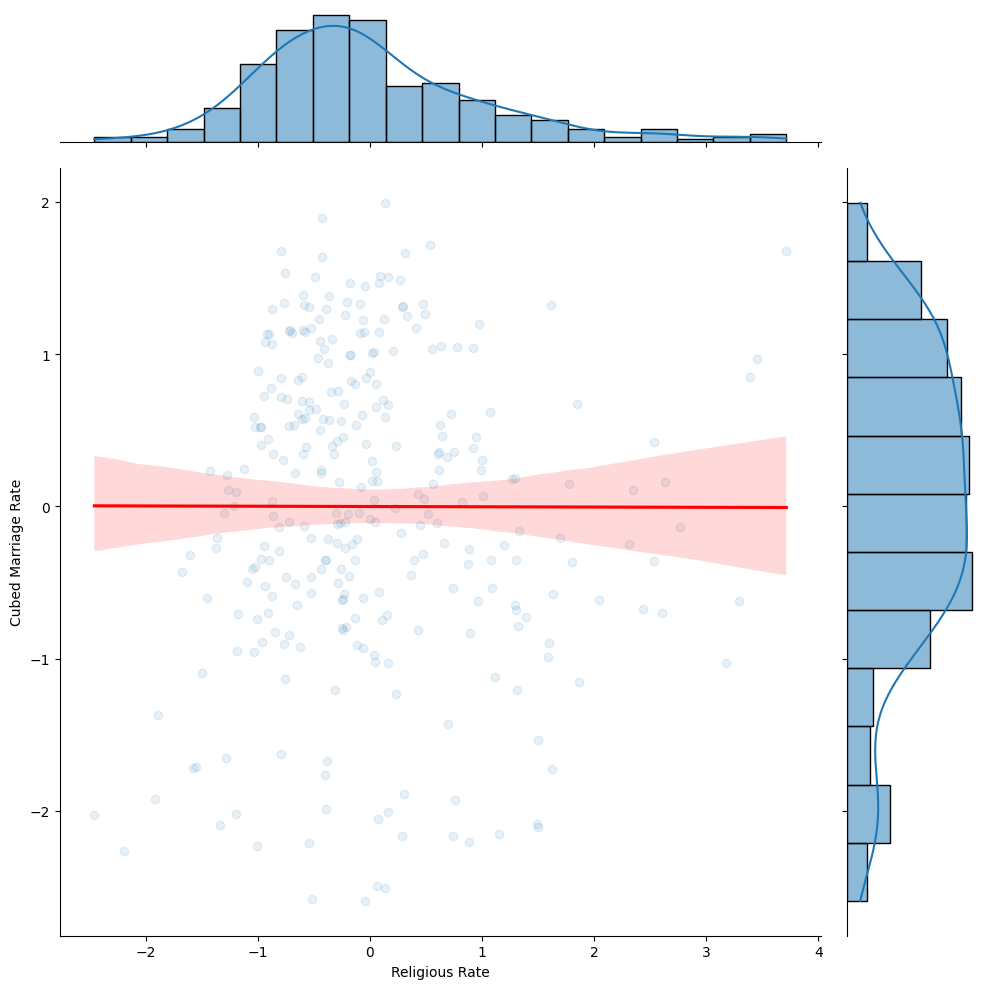

In [68]:
g = sns.jointplot(data=overall_data_scaled,
                  x='religious_rate_scaled',
                  y='cubed_marriage_rate_scaled',
                  kind="reg",
                  scatter_kws=dict(alpha=0.1),
                  line_kws=dict(color='red'),
                  height=10)

# Set axis labels
g.set_axis_labels('Religious Rate', 'Cubed Marriage Rate')

plt.show()

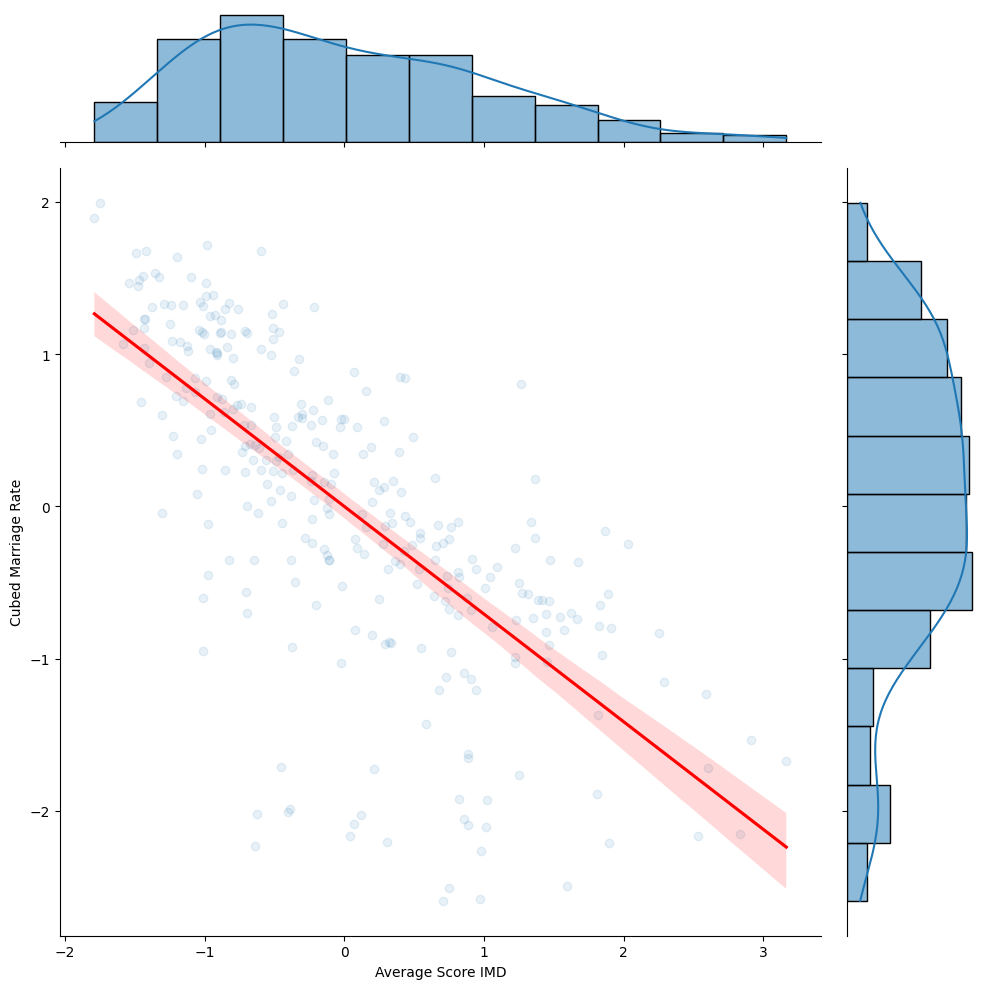

In [69]:
g = sns.jointplot(data=overall_data_scaled,
                  x='imd_scaled',
                  y='cubed_marriage_rate_scaled',
                  kind="reg",
                  scatter_kws=dict(alpha=0.1),
                  line_kws=dict(color='red'),
                  height=10)

# Set axis labels
g.set_axis_labels('Average Score IMD', 'Cubed Marriage Rate')

plt.show()

### ***Spatial Autocorrelation*** ###

Reference: https://pysal.org/notebooks/viz/splot/esda_morans_viz.html

In [70]:
overall_data.columns

Index(['district_code', 'district_name', 'imd', 'income', 'employment',
       'education', 'health', 'crime', 'barriers', 'living_environment',
       'marriage_rate', 'religious_rate', 'population_density'],
      dtype='object')

In [71]:
# Read GeoJSON file into GeoDataFrame
gdf = gpd.read_file(geojson_path)

# add imd and religious_rate from overall_data to regression_3
before_merge = overall_data[['district_code', 'district_name', 'imd', 'religious_rate', 'population_density', 'marriage_rate']]

merged_data = before_merge.merge(gdf, left_on='district_code', right_on='lad19cd')
merged_data = merged_data.drop(columns = ['lad19cd', 'lad19nm', 'FID'])
merged_data.head()

,district_code,district_name,imd,religious_rate,population_density,marriage_rate,RAvgRank,RAvgScor,RPLMD10,Shape__Area,Shape__Length,geometry
0,E06000001,Hartlepool,35.037,0.577601,999,0.422544,25,10,10,2.795798e+08,120552.822377,"MULTIPOLYGON (((-1.27024 54.72716, -1.26821 54..."
1,E06000002,Middlesbrough,40.460,0.615277,2616,0.394321,16,5,1,1.598553e+08,72792.694184,"MULTIPOLYGON (((-1.23001 54.58410, -1.23015 54..."
2,E06000003,Redcar and Cleveland,29.792,0.575181,560,0.439915,62,40,29,7.268829e+08,166334.422625,"MULTIPOLYGON (((-1.13747 54.64571, -1.13873 54..."
3,E06000004,Stockton-on-Tees,25.790,0.588367,963,0.455624,113,73,39,6.087220e+08,199134.726817,"MULTIPOLYGON (((-1.31774 54.64524, -1.31713 54..."
4,E06000005,Darlington,25.657,0.582646,541,0.442464,103,77,47,5.862094e+08,182218.352941,"POLYGON ((-1.43834 54.59507, -1.43806 54.59494..."


In [72]:
# Convert merged data to GeoDataFrame
merged_data = gpd.GeoDataFrame(merged_data, geometry='geometry')

# Create spatial weights matrix
w = Queen.from_dataframe(merged_data)
w.transform = 'r'

# Standardize the variable of interest
y = (merged_data['imd'] - merged_data['imd'].mean()) / merged_data['imd'].std()

# Calculate Moran's I for spatial autocorrelation
moran_i = Moran(y, w)

print(f"Moran's I: {moran_i.I}")
print(f"p-value: {moran_i.p_sim}")

<ipython-input-72-075ba20a1937>:5: FutureWarning:

`use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning



('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
Moran's I: 0.35639910131902014
p-value: 0.001


/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:224: UserWarning:

The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 43, 49.



In [73]:
from tabulate import tabulate

# Assign the Moran's I test results to variables
morans_I = 0.35639910131902014
p_value = 0.001

# Define the data for the table
morans_test_data = [
    ["Moran's I", morans_I],
    ["p-value", p_value]
]

# Create the table using tabulate
morans_test_table = tabulate(morans_test_data, headers=["Moran's I Spatial Correlation", "Results"], tablefmt="pretty")

# Print the table
print("Results of the Moran's I test")
print(morans_test_table)


Results of the Moran's I test
+-------------------------------+---------------------+
| Moran's I Spatial Correlation |       Results       |
+-------------------------------+---------------------+
|           Moran's I           | 0.35639910131902014 |
|            p-value            |        0.001        |
+-------------------------------+---------------------+


### ***Geographically Weighted Regression*** ###

Reference: https://deepnote.com/@carlos-mendez/PYTHON-GWR-and-MGWR-71dd8ba9-a3ea-4d28-9b20-41cc8a282b7a

In [74]:
merged_data = merged_data.merge(overall_data_scaled[['district_code', 'cubed_marriage_rate', 'inverse_population_density']], on='district_code')
merged_data.head()

,district_code,district_name,imd,religious_rate,population_density,marriage_rate,RAvgRank,RAvgScor,RPLMD10,Shape__Area,Shape__Length,geometry,cubed_marriage_rate,inverse_population_density
0,E06000001,Hartlepool,35.037,0.577601,999,0.422544,25,10,10,2.795798e+08,120552.822377,"MULTIPOLYGON (((-1.27024 54.72716, -1.26821 54...",0.075442,0.001001
1,E06000002,Middlesbrough,40.460,0.615277,2616,0.394321,16,5,1,1.598553e+08,72792.694184,"MULTIPOLYGON (((-1.23001 54.58410, -1.23015 54...",0.061313,0.000382
2,E06000003,Redcar and Cleveland,29.792,0.575181,560,0.439915,62,40,29,7.268829e+08,166334.422625,"MULTIPOLYGON (((-1.13747 54.64571, -1.13873 54...",0.085134,0.001786
3,E06000004,Stockton-on-Tees,25.790,0.588367,963,0.455624,113,73,39,6.087220e+08,199134.726817,"MULTIPOLYGON (((-1.31774 54.64524, -1.31713 54...",0.094585,0.001038
4,E06000005,Darlington,25.657,0.582646,541,0.442464,103,77,47,5.862094e+08,182218.352941,"POLYGON ((-1.43834 54.59507, -1.43806 54.59494...",0.086623,0.001848


In [75]:
import libpysal as ps
import geopandas as gpd
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

merged_data = merged_data.to_crs(epsg=27700)
centroids = merged_data.geometry.centroid
coords = list(zip(centroids.x, centroids.y))

y = merged_data['cubed_marriage_rate'].values.reshape((-1, 1))
X = merged_data[['imd', 'religious_rate', 'inverse_population_density']].values

gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search()

gwr_model = GWR(coords, y, X, bw=gwr_bw)
gwr_results = gwr_model.fit()

print(gwr_results.summary())

Model type                                                         Gaussian
Number of observations:                                                 305
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              0.123
Log-likelihood:                                                     759.169
AIC:                                                              -1510.338
AICc:                                                             -1508.138
BIC:                                                              -1721.691
R2:                                                                   0.623
Adj. R2:                                                              0.619

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

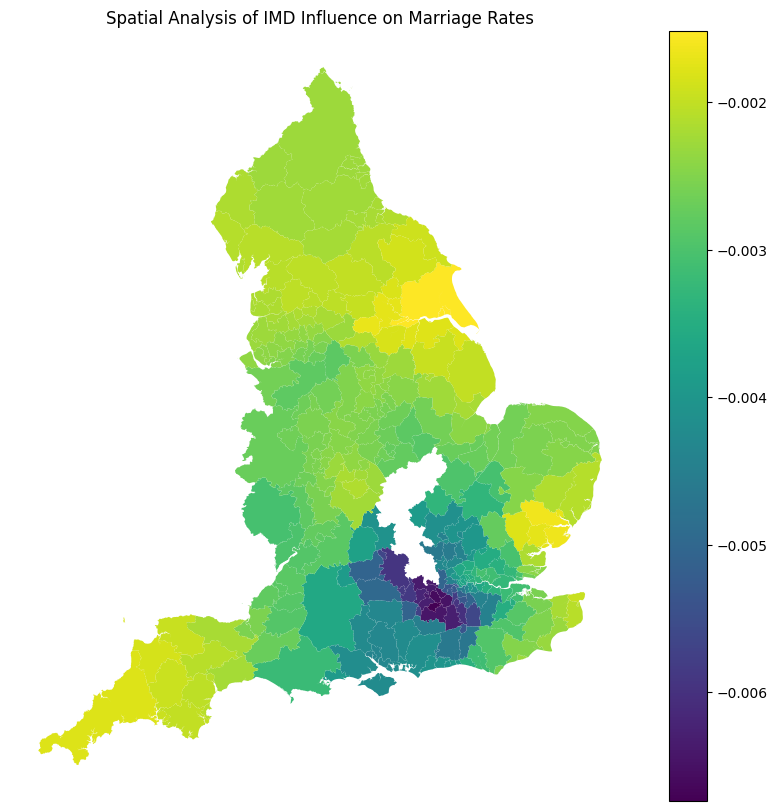

In [76]:
merged_data['gwr_coefficient'] = gwr_results.params[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_data.plot(column='gwr_coefficient', ax=ax, legend=True)

ax.set_title('Spatial Analysis of IMD Influence on Marriage Rates')
ax.set_axis_off()

plt.show()

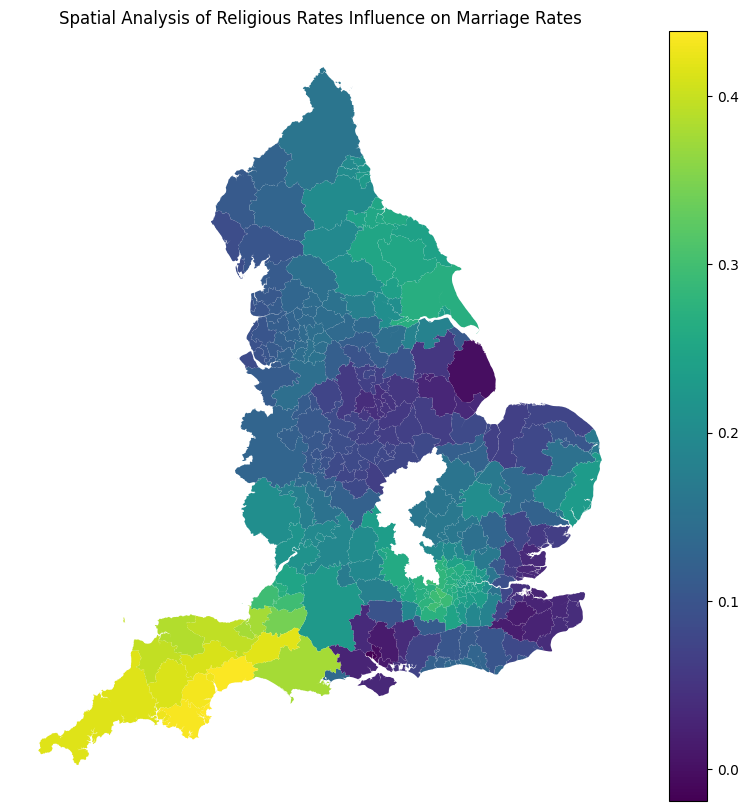

In [77]:
merged_data['gwr_coefficient'] = gwr_results.params[:, 2]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_data.plot(column='gwr_coefficient', ax=ax, legend=True)

ax.set_title('Spatial Analysis of Religious Rates Influence on Marriage Rates')
ax.set_axis_off()

plt.show()

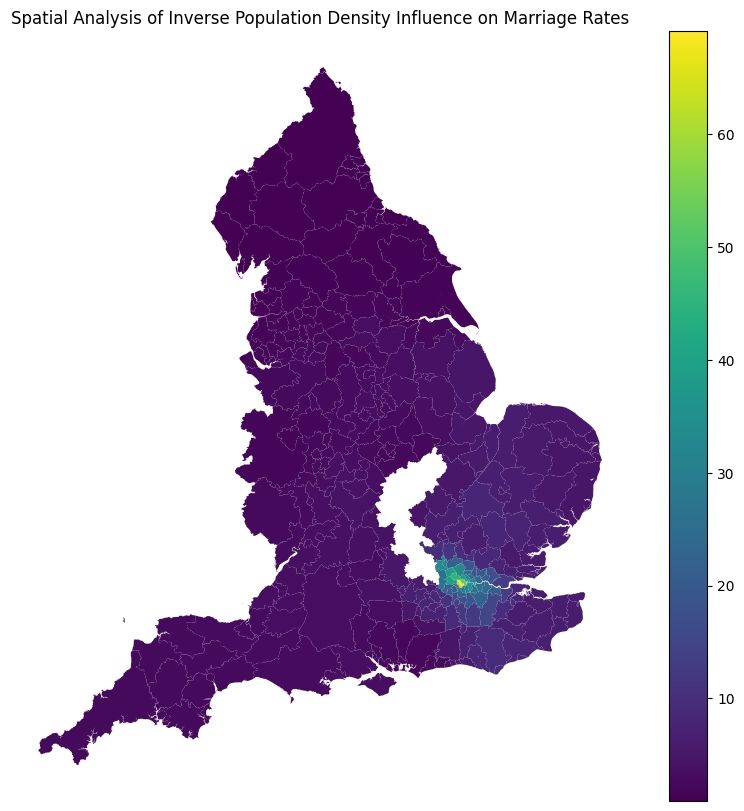

In [78]:
merged_data['gwr_coefficient'] = gwr_results.params[:, 3]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_data.plot(column='gwr_coefficient', ax=ax, legend=True)

ax.set_title('Spatial Analysis of Inverse Population Density Influence on Marriage Rates')
ax.set_axis_off()

plt.show()

# Regression Model #4

In [79]:
overall_data_scaled.columns

Index(['district_code', 'district_name', 'imd_scaled', 'income_scaled',
       'employment_scaled', 'education_scaled', 'health_scaled',
       'crime_scaled', 'barriers_scaled', 'living_environment_scaled',
       'marriage_rate_scaled', 'religious_rate_scaled',
       'population_density_scaled', 'cubed_marriage_rate',
       'cubed_marriage_rate_scaled', 'marriage_rate', 'imd', 'religious_rate',
       'population_density', 'inverse_population_density',
       'inverse_population_density_scaled'],
      dtype='object')

In [80]:
regression_4 = overall_data_scaled.iloc[:, [0,1,2,3,4,5,6,7,8,9,11,18,20]]
regression_4.head()

,district_code,district_name,imd_scaled,income_scaled,employment_scaled,education_scaled,health_scaled,crime_scaled,barriers_scaled,living_environment_scaled,religious_rate_scaled,population_density,inverse_population_density_scaled
0,E06000001,Hartlepool,1.909051,2.449123,2.666077,1.080265,1.568870,1.351263,-1.182477,-1.569034,-0.252146,999,-0.468834
1,E06000002,Middlesbrough,2.589150,2.957425,2.839828,2.065280,2.086010,1.610942,-1.191831,-0.883322,0.230681,2616,-0.606036
2,E06000003,Redcar and Cleveland,1.251275,1.520920,2.086908,0.795247,1.443166,0.527985,-1.198808,-1.471664,-0.283152,560,-0.294829
3,E06000004,Stockton-on-Tees,0.749383,1.034718,1.218154,0.453500,1.274499,0.049022,-0.924352,-1.676255,-0.114179,963,-0.460536
4,E06000005,Darlington,0.732703,0.791617,1.015445,0.753302,1.032636,1.335875,-1.547149,-1.356310,-0.187486,541,-0.280922


In [81]:
# Fit a linear regression model
lm_4_results = smf.ols('cubed_marriage_rate ~ income_scaled + employment_scaled + education_scaled + health_scaled + crime_scaled + barriers_scaled + living_environment_scaled + religious_rate_scaled + inverse_population_density_scaled', data=overall_data_scaled).fit()

homoscedasticity_test(lm_4_results)

                             OLS Regression Results                            
Dep. Variable:     cubed_marriage_rate   R-squared:                       0.793
Model:                             OLS   Adj. R-squared:                  0.787
Method:                  Least Squares   F-statistic:                     125.8
Date:                 Thu, 28 Dec 2023   Prob (F-statistic):           1.60e-95
Time:                         20:41:46   Log-Likelihood:                 850.84
No. Observations:                  305   AIC:                            -1682.
Df Residuals:                      295   BIC:                            -1644.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

### ***Multi Collinearity*** ###

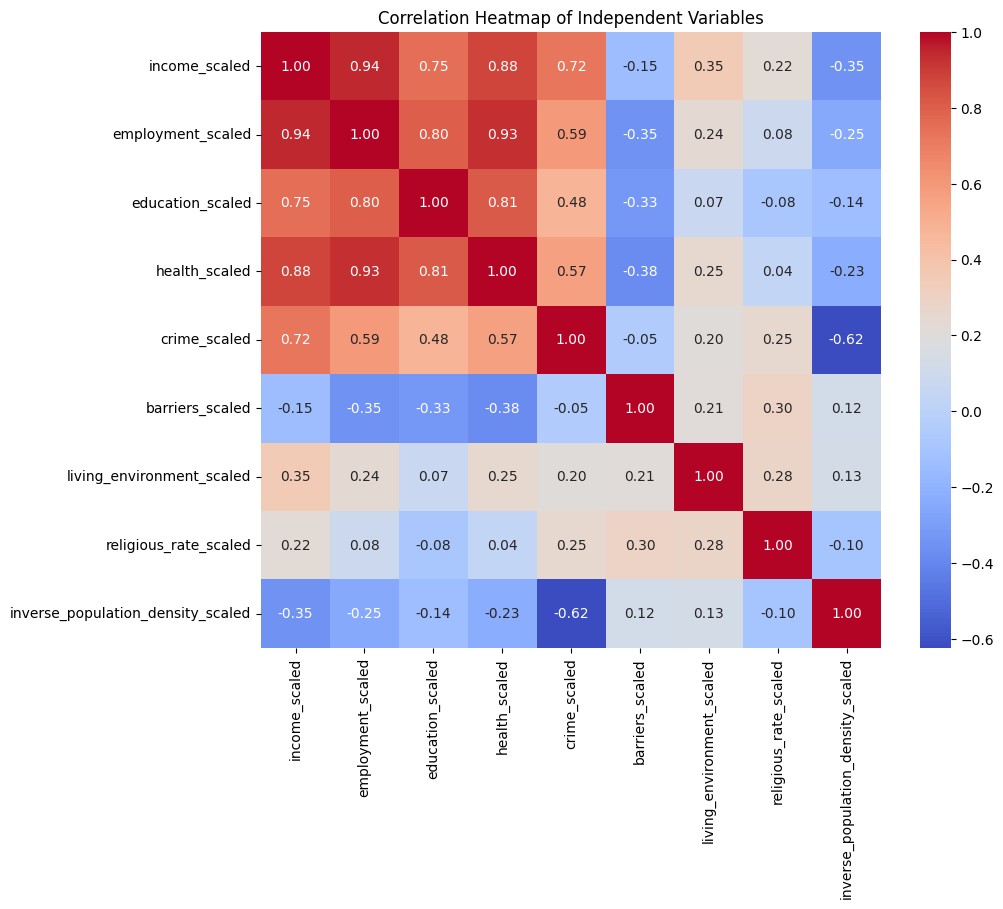

In [82]:
independent_vars = regression_4[['income_scaled', 'employment_scaled', 'education_scaled', 'health_scaled', 'crime_scaled', 'barriers_scaled', 'living_environment_scaled', 'religious_rate_scaled', 'inverse_population_density_scaled']]

# Calculate the correlation matrix
correlation_matrix = independent_vars.corr()

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap of Independent Variables')
plt.show()

In [83]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to drop columns based on high VIF values
def drop_column_using_vif(data, list_var_not_to_remove=None, thresh=5):
    while True:
        # Adding a constant for VIF calculation
        data_with_const = sm.add_constant(data)
        vif_data = pd.Series([variance_inflation_factor(data_with_const.values, i)
                              for i in range(data_with_const.shape[1])],
                             index=data_with_const.columns).sort_values(ascending=False)

        # Dropping the constant term VIF value
        vif_data = vif_data.drop('const')

        # If specified, dropping the variables not to be removed from the VIF DataFrame
        if list_var_not_to_remove:
            vif_data = vif_data.drop(list_var_not_to_remove)

        # Checking the max VIF value against the threshold
        max_vif = vif_data.max()
        if max_vif > thresh:
            # Dropping the variable with the highest VIF value
            index_to_drop = vif_data.idxmax()
            print(f'Dropping: {index_to_drop} with VIF {max_vif}')
            data = data.drop(columns=index_to_drop)
        else:
            break
    return data

# List of variables as per your correlation matrix
independent_vars = regression_4[['income_scaled', 'employment_scaled', 'education_scaled', 'health_scaled', 'crime_scaled', 'barriers_scaled', 'living_environment_scaled', 'religious_rate_scaled', 'inverse_population_density_scaled']]

# Applying the function to drop columns with high VIF
reduced_data = drop_column_using_vif(independent_vars)

# Print the remaining columns after VIF reduction
print("The columns remaining after VIF selection are:")
print("The maximum VIF value was:", max_vif)
print(reduced_data.columns)


Dropping: income_scaled with VIF 30.35550856823862
Dropping: health_scaled with VIF 8.374498069523382
The columns remaining after VIF selection are:
The maximum VIF value was: 1.1096729016259226
Index(['employment_scaled', 'education_scaled', 'crime_scaled',
       'barriers_scaled', 'living_environment_scaled', 'religious_rate_scaled',
       'inverse_population_density_scaled'],
      dtype='object')


In [110]:
from prettytable import PrettyTable

# Create an instance of PrettyTable
table = PrettyTable()

# Define the column names
table.field_names = ["VIF analysis Model 4", "Outcome"]

# Add rows to the table with the data
table.add_row(["Remaining columns after VIF selection", "employment_scaled, education_scaled, crime_scaled, barriers_scaled, living_environment_scaled, religious_rate_scaled, inverse_population_density_scaled"])
table.add_row(["Maximum VIF value", "1.1096729016259226"])

# Print the table
print(table)

+---------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|          VIF analysis Model 4         |                                                                         Outcome                                                                         |
+---------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------+
| Remaining columns after VIF selection | employment_scaled, education_scaled, crime_scaled, barriers_scaled, living_environment_scaled, religious_rate_scaled, inverse_population_density_scaled |
|           Maximum VIF value           |                                                                    1.1096729016259226                                                                   |
+-------------------

### Regression Model 4 after Multicollinearity ###

In [85]:
column_names_after_vif = ['inverse_population_density_scaled', 'religious_rate_scaled', 'education_scaled', 'crime_scaled', 'living_environment_scaled', 'barriers_scaled', 'employment_scaled']

# Fit a linear regression model without 'income' and 'employment'
lm_4_model = sm.OLS(overall_data_scaled['cubed_marriage_rate'], sm.add_constant(regression_4[column_names_after_vif]))
lm_4_results = lm_4_model.fit()

# Display the regression results
print(lm_4_results.summary())

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(lm_4_results.resid, lm_4_results.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print("\nBreusch-Pagan test:")
for label, value in zip(labels, bp_test):
    print(f"{label}: {value}")

                             OLS Regression Results                            
Dep. Variable:     cubed_marriage_rate   R-squared:                       0.696
Model:                             OLS   Adj. R-squared:                  0.689
Method:                  Least Squares   F-statistic:                     97.07
Date:                 Thu, 28 Dec 2023   Prob (F-statistic):           5.85e-73
Time:                         20:41:46   Log-Likelihood:                 791.92
No. Observations:                  305   AIC:                            -1568.
Df Residuals:                      297   BIC:                            -1538.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

### Regression Model 4 after dropping "education" ###

In [86]:
column_names_after_vif = ['inverse_population_density_scaled', 'religious_rate_scaled', 'crime_scaled', 'living_environment_scaled', 'barriers_scaled', 'employment_scaled']

lm_4_model = sm.OLS(overall_data_scaled['cubed_marriage_rate'], sm.add_constant(regression_4[column_names_after_vif]))
lm_4_results = lm_4_model.fit()

print(lm_4_results.summary())

bp_test = het_breuschpagan(lm_4_results.resid, lm_4_results.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print("\nBreusch-Pagan test:")
for label, value in zip(labels, bp_test):
    print(f"{label}: {value}")

                             OLS Regression Results                            
Dep. Variable:     cubed_marriage_rate   R-squared:                       0.694
Model:                             OLS   Adj. R-squared:                  0.688
Method:                  Least Squares   F-statistic:                     112.7
Date:                 Thu, 28 Dec 2023   Prob (F-statistic):           1.23e-73
Time:                         20:41:46   Log-Likelihood:                 791.05
No. Observations:                  305   AIC:                            -1568.
Df Residuals:                      298   BIC:                            -1542.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [111]:
from tabulate import tabulate

# Assign the actual LM test results to variables
lm_statistic = 51.4235276801171
lm_pvalue = 2.4350406832605785e-09

# Define the data for the table
bp_lm_test_data = [
    ["Test Statistic", lm_statistic],
    ["p-value", lm_pvalue]
]

# Create the table using tabulate
bp_lm_test_table = tabulate(bp_lm_test_data, headers=["Test", "Value"], tablefmt="pretty")

# Print the table
print("Results of the Breusch-Pagan Test Model 4")
print(bp_lm_test_table)

Results of the Breusch-Pagan Test Model 4
+----------------+------------------------+
|      Test      |         Value          |
+----------------+------------------------+
| Test Statistic |    51.4235276801171    |
|    p-value     | 2.4350406832605785e-09 |
+----------------+------------------------+


### ***Outliers*** ###

Leverage v.s. Studentized Residuals


,district_code,district_name,imd_scaled,income_scaled,employment_scaled,education_scaled,health_scaled,crime_scaled,barriers_scaled,living_environment_scaled,religious_rate_scaled,population_density,inverse_population_density_scaled,cooks,dffits,leverage,resid_student
0,E06000001,Hartlepool,1.909051,2.449123,2.666077,1.080265,1.568870,1.351263,-1.182477,-1.569034,-0.252146,999,-0.468834,7.316185e-07,-0.002259,0.046021,-0.010286
1,E06000002,Middlesbrough,2.589150,2.957425,2.839828,2.065280,2.086010,1.610942,-1.191831,-0.883322,0.230681,2616,-0.606036,5.322982e-04,-0.060948,0.039968,-0.298709
2,E06000003,Redcar and Cleveland,1.251275,1.520920,2.086908,0.795247,1.443166,0.527985,-1.198808,-1.471664,-0.283152,560,-0.294829,4.264415e-04,-0.054552,0.033196,-0.294401
3,E06000004,Stockton-on-Tees,0.749383,1.034718,1.218154,0.453500,1.274499,0.049022,-0.924352,-1.676255,-0.114179,963,-0.460536,1.215952e-03,-0.092157,0.024154,-0.585771
4,E06000005,Darlington,0.732703,0.791617,1.015445,0.753302,1.032636,1.335875,-1.547149,-1.356310,-0.187486,541,-0.280922,1.565798e-03,-0.104581,0.029149,-0.603553


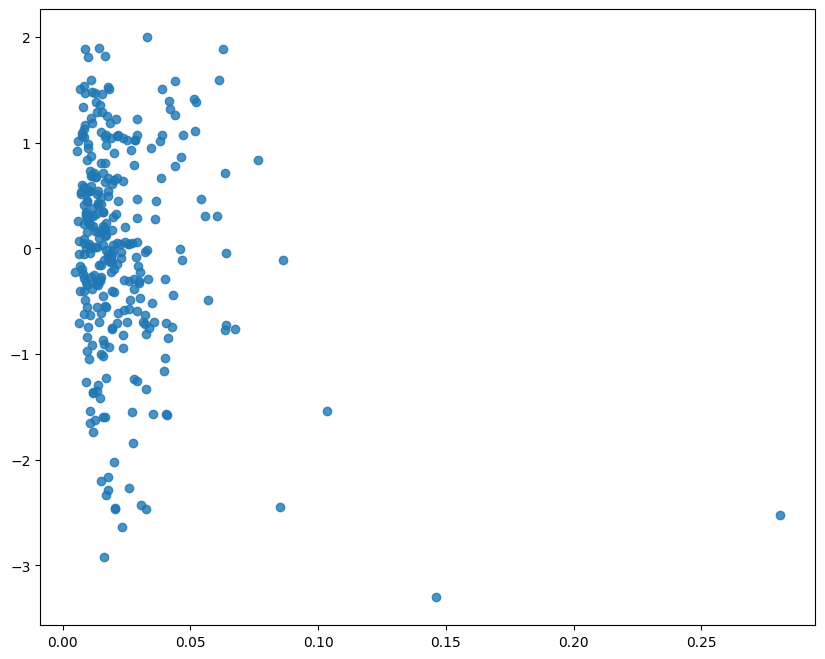

In [88]:
influence_4 = lm_4_results.get_influence()
resid_student_4 = influence_4.resid_studentized_external
(cooks_4, p) = influence_4.cooks_distance
(dffits_4, p) = influence_4.dffits
leverage_4 = influence_4.hat_matrix_diag

print('Leverage v.s. Studentized Residuals')
sns.regplot(x=leverage_4, y=lm_4_results.resid_pearson,  fit_reg=False)

regressiondiagnostics_4 = pd.concat([pd.Series(cooks_4, name = "cooks"), pd.Series(dffits_4, name = "dffits"), pd.Series(leverage_4, name = "leverage"), pd.Series(resid_student_4, name = "resid_student")], axis = 1)
regressiondiagnostics_4 = pd.concat([regression_4, regressiondiagnostics_4], axis = 1)
regressiondiagnostics_4.head()

In [89]:
r = regressiondiagnostics_4.resid_student

table = PrettyTable()
table.field_names = ['district_code', 'district_name']

for index, row in regression_4[['district_code', 'district_name']][abs(r) > 2].iterrows():
    table.add_row([row['district_code'], row['district_name']])

table.title = "Observations with studentised residuals greater than 2"

print(table)

+--------------------------------------------------------+
| Observations with studentised residuals greater than 2 |
+--------------------+-----------------------------------+
|   district_code    |           district_name           |
+--------------------+-----------------------------------+
|     E06000014      |                York               |
|     E07000008      |             Cambridge             |
|     E07000030      |                Eden               |
|     E07000041      |               Exeter              |
|     E07000138      |              Lincoln              |
|     E07000148      |              Norwich              |
|     E07000166      |           Richmondshire           |
|     E07000178      |               Oxford              |
|     E08000021      |        Newcastle upon Tyne        |
|     E08000032      |              Bradford             |
|     E09000001      |           City of London          |
|     E09000007      |               Camden             

In [90]:
# A point with leverage greater than (2k+2)/n should be  examined, where k is the number of predictors and n is the number of observations.
# In our example this works out to (2*10+2)/51 = 0.07189542

table = PrettyTable()
table.field_names = ['district_code', 'district_name']

#adding rows to the table
for index, row in regression_4[['district_code', 'district_name']][abs(leverage_4) > 0.07189542].iterrows():
    table.add_row([row['district_code'], row['district_name']])

#add a title
table.title = "Observations with a leverage greater than 0.07189542"

#print the table
print(table)

+------------------------------------------------------+
| Observations with a leverage greater than 0.07189542 |
+---------------------+--------------------------------+
|    district_code    |         district_name          |
+---------------------+--------------------------------+
|      E07000030      |              Eden              |
|      E07000166      |         Richmondshire          |
|      E07000167      |            Ryedale             |
|      E09000001      |         City of London         |
|      E09000002      |      Barking and Dagenham      |
|      E09000025      |             Newham             |
+---------------------+--------------------------------+


In [91]:
table = PrettyTable()
table.field_names = ['district_code', 'district_name']

for index, row in regression_4[['district_code', 'district_name']][abs(cooks_4) > 1].iterrows():
    table.add_row([row['district_code'], row['district_name']])

table.title = "Observations with a Cook's Distance greater than 1"
print(table)

+----------------------------------------------------+
| Observations with a Cook's Distance greater than 1 |
+-------------------------+--------------------------+
|      district_code      |      district_name       |
+-------------------------+--------------------------+
+-------------------------+--------------------------+


# Regression Tables #

In [92]:
table=summary_col( # create a regression table
    [lm_results_1, lm_2_results, lm_3_results], # pass the models to the summary_col function
    stars=True, # add stars denoting the p-values of the coefficient to the table; * p<0.05, ** p<0.01, *** p<0.001
    float_format='%0.3f', # set the decimal places to 3
    model_names=['model_1', 'model_2', 'model_3', 'logged_model_3'], # set the name of the model
    info_dict = {"N":lambda x: "{0:d}".format(int(x.nobs))}) # add the number of observations to the table

print(table)


                                   model_1   model_2   model_3 
---------------------------------------------------------------
Intercept                         0.102***  0.102***  0.102*** 
                                  (0.001)   (0.001)   (0.001)  
imd_scaled                        -0.023*** -0.024*** -0.021***
                                  (0.001)   (0.001)   (0.001)  
religious_rate_scaled                       0.004***  0.005*** 
                                            (0.001)   (0.001)  
inverse_population_density_scaled                     0.011*** 
                                                      (0.001)  
R-squared                         0.500     0.518     0.623    
R-squared Adj.                    0.499     0.515     0.619    
N                                 305       305       305      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [93]:
table=summary_col( # create a regression table
    [lm_4_results], # pass the models to the summary_col function
    stars=True, # add stars denoting the p-values of the coefficient to the table; * p<0.05, ** p<0.01, *** p<0.001
    float_format='%0.3f', # set the decimal places to 3
    model_names=['model_4'], # set the name of the model
    info_dict = {"N":lambda x: "{0:d}".format(int(x.nobs))}) # add the number of observations to the table

print(table)


                                   model_4 
-------------------------------------------
const                             0.102*** 
                                  (0.001)  
inverse_population_density_scaled 0.011*** 
                                  (0.001)  
religious_rate_scaled             0.009*** 
                                  (0.001)  
crime_scaled                      -0.009***
                                  (0.002)  
living_environment_scaled         -0.011***
                                  (0.001)  
barriers_scaled                   -0.006***
                                  (0.001)  
employment_scaled                 -0.012***
                                  (0.002)  
R-squared                         0.694    
R-squared Adj.                    0.688    
N                                 305      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


# Visualizations #

### ***Bivariate Choropleth Maps*** ###

Reference: https://www.kaggle.com/code/yotkadata/bivariate-choropleth-map-using-plotly

In [94]:
color_sets = {
    'pink-blue':   ['#e8e8e8', '#ace4e4', '#5ac8c8', '#dfb0d6', '#a5add3', '#5698b9', '#be64ac', '#8c62aa', '#3b4994'],
    'teal-red':    ['#e8e8e8', '#e4acac', '#c85a5a', '#b0d5df', '#ad9ea5', '#985356', '#64acbe', '#627f8c', '#574249'],
    'blue-organe': ['#fef1e4', '#fab186', '#f3742d',  '#97d0e7', '#b0988c', '#ab5f37', '#18aee5', '#407b8f', '#5c473d'],
    'yellow-green-blue': ['#FFFFCB', '#F0E68C', '#FAC205', '#FF7F50', '#EF4026', '#E50000', '#DA70D6', '#9A0EEA', '#800080']
}

In [95]:
overall_data = overall_data.merge(gdf, left_on='district_code', right_on='lad19cd')

In [96]:
merged_data['imd'].fillna(0, inplace=True)
merged_data['marriage_rate'].fillna(0, inplace=True)
merged_data['religious_rate'].fillna(0, inplace=True)
merged_data['population_density'].fillna(0, inplace=True)

marriage_norm = ((merged_data['marriage_rate'] - merged_data['marriage_rate'].min()) / (merged_data['marriage_rate'].max() - merged_data['marriage_rate'].min()) * (len(color_sets) - 1)).astype(int)

<ipython-input-97-ffb2ff5e5d00>:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



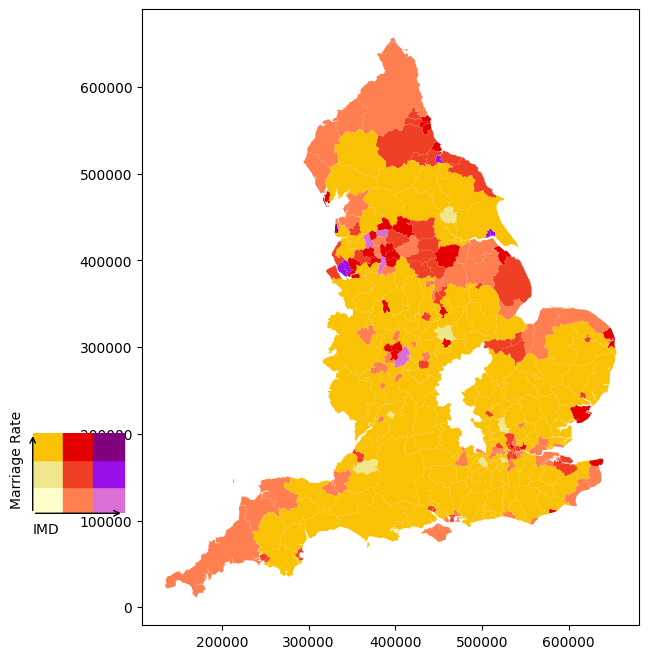

In [97]:
# Create a bivariate choroplethmap
fig, ax = plt.subplots(1, 1)

cmap = plt.cm.get_cmap('RdBu')

# Choose a color set
color_set = color_sets['yellow-green-blue']

# Normalize the IMD data to suit range of the color set
imd_norm = ((merged_data['imd'] - merged_data['imd'].min()) / (merged_data['imd'].max() - merged_data['imd'].min()) * (len(color_set) - 1)).astype(int)


colors = [color_set[max(imd_norm.iloc[i], marriage_norm.iloc[i])] for i in range(len(merged_data))]

merged_data['geometry'].plot(ax=ax, color=colors)


ax2 = fig.add_axes([0.15, 0.25, 0.1, 0.1])
alpha = 1


for i in range(3):
    for j in range(3):
        ax2.axvspan(xmin=i/3, xmax=(i+1)/3, ymin=j/3, ymax=(j+1)/3, alpha=alpha, color=color_set[i*3+j])

ax2.tick_params(axis='both', which='both', length=0)
ax2.axis('off')
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.text(s='IMD', x=0, y=-0.25)
ax2.text(s='Marriage Rate', x=-0.25, y=0.1, rotation=90)

plt.show()

<ipython-input-98-158c0a39532e>:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



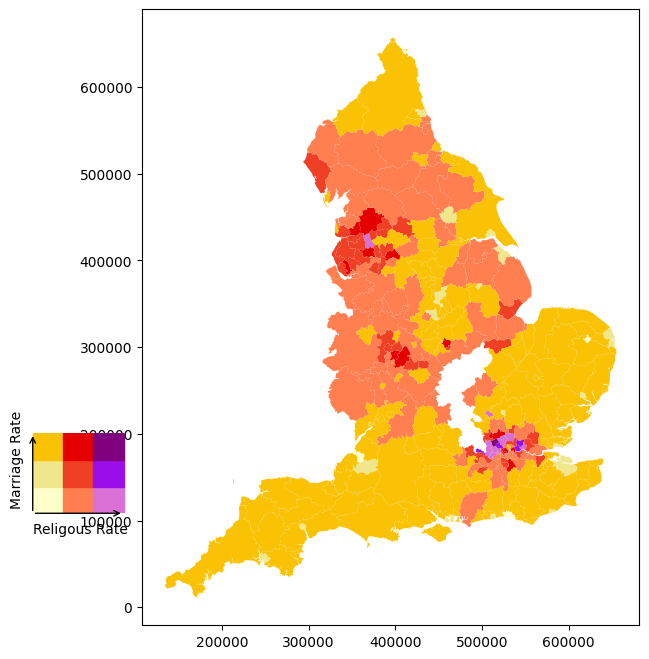

In [98]:

fig, ax = plt.subplots(1, 1)


cmap = plt.cm.get_cmap('RdBu')


color_set = color_sets['yellow-green-blue']


religious_norm = ((merged_data['religious_rate'] - merged_data['religious_rate'].min()) / (merged_data['religious_rate'].max() - merged_data['religious_rate'].min()) * (len(color_set) - 1)).astype(int)

colors = [color_set[max(religious_norm.iloc[i], marriage_norm.iloc[i])] for i in range(len(merged_data))]


merged_data['geometry'].plot(ax=ax, color=colors)


ax2 = fig.add_axes([0.15, 0.25, 0.1, 0.1])
alpha = 1


for i in range(3):
    for j in range(3):
        ax2.axvspan(xmin=i/3, xmax=(i+1)/3, ymin=j/3, ymax=(j+1)/3, alpha=alpha, color=color_set[i*3+j])


ax2.tick_params(axis='both', which='both', length=0)
ax2.axis('off')
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.text(s='Religous Rate', x=0, y=-0.25)
ax2.text(s='Marriage Rate', x=-0.25, y=0.1, rotation=90)

plt.show()


<ipython-input-99-ec5645f80d17>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



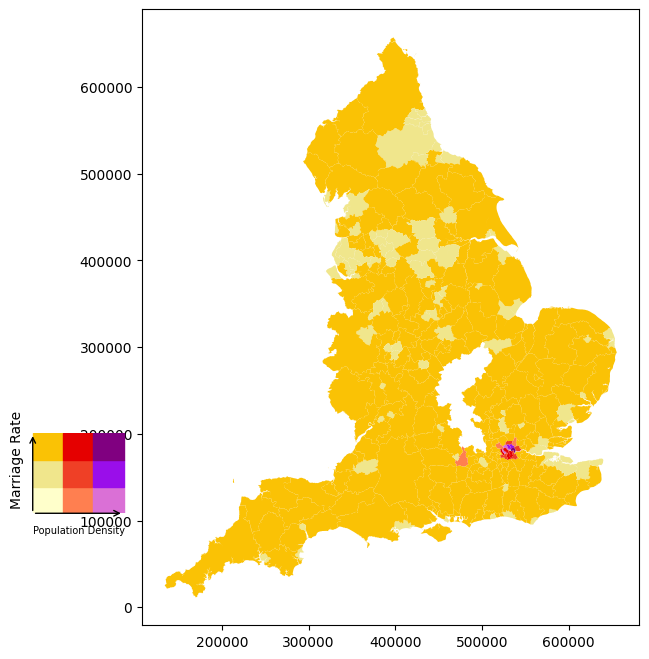

In [99]:

fig, ax = plt.subplots(1, 1)

cmap = plt.cm.get_cmap('RdBu')

color_set = color_sets['yellow-green-blue']

population_norm = ((merged_data['population_density'] - merged_data['population_density'].min()) / (merged_data['population_density'].max() - merged_data['population_density'].min()) * (len(color_set) - 1)).astype(int)

colors = [color_set[max(population_norm.iloc[i], marriage_norm.iloc[i])] for i in range(len(merged_data))]

merged_data['geometry'].plot(ax=ax, color=colors)

ax2 = fig.add_axes([0.15, 0.25, 0.1, 0.1])
alpha = 1

for i in range(3):
    for j in range(3):
        ax2.axvspan(xmin=i/3, xmax=(i+1)/3, ymin=j/3, ymax=(j+1)/3, alpha=alpha, color=color_set[i*3+j])

ax2.tick_params(axis='both', which='both', length=0)
ax2.axis('off')
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.text(s='Population Density', x=0, y=-0.25, fontsize=7)
ax2.text(s='Marriage Rate', x=-0.25, y=0.1, rotation=90)

plt.show()
